# 02 Machine Learning

## Proyecto: Credit Card Leads

### Equipo:
- Javier De La Rosa Mondragon
- Luis Fernando Merino Nambo
- Salomon Ramírez

![Leads](credit-cards.jpg)

## Objetivos

Analizar, limpiar y usar el train dataset para identificar clientes con tendencia a adquirur una tarjeta de crédito tomando como features las características del cliente.

Explorar las pistas que nos dan los diferentes modelos y tecnicas de clasificación para entender más cómo se pueden aplicar en este y en casos donde puede aplicar ML.

Poner en práctica los conocimientos adquiridos durante el módulo.


##  Dataset

Credit Card Lead Prediction

https://www.kaggle.com/datasets/shelvigarg/credit-card-buyers

- ~250,000 datos en train set

- ~100,000 datos en test set (sin eqtiquetas)

- 10 Features
    - ID
    - Sexo
    - Edad
    - Región
    - Ocupación
    - Channel code (medio de comunicación para ofrecer la tarjeta)
    - Vintage (meses de historial crediticio)
    - Credit product (el cliente cuenta ya con un producto de crédito)
    - Balance promedio en cuenta
    - Es cliente activo
    


- 1 Columna de target
    - Lead (aceptó la tarjeta de crédito ofecida)

## Retos

- El dataset que utlilzaremos es muy grande, lo cual requiere que encontremos soluciones para trabajar con él y el poder de cómputo requerido puede ser poco accesible para trabajarlo dentro de rangos de tiempo compatibles con otras actividades.
- De inmediato se puede observar que casi todas nuestras variables son categóricas. Para poder utlizarlas será necesario manipular los datos y buscar hiperparámetros adecuados para ellas (valores, distribuciones de probabilidad, etc.)

## Código

In [1]:
# VARIABLES PARA EJECUCIÓN
DATA_FRACTION = 1 # parte del dataset completo de datos a utlizar
LONG_TIME_CELLS = True # ejecutar las celdas de EDA que tardan mucho
SMOTE_FRACTION = .5 # parte del dataset sobremuestreado a utlizar
DATA_TO_USE = 'over' # 'over' | 'sub' | 'orig'  # los datos que se usarán en el entrenamiento final

### Importación de bibliotecas 

In [2]:
# numerical y Dfs
import pandas as pd
import numpy as np

# ML:
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, VarianceThreshold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2 # selección de features categoricas
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN

# SMOTE oversamplig
from imblearn.over_sampling import SMOTE

# árboles de decisión
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# visualización de árboles con dtreeviz
from sklearn import tree
#from dtreeviz import model
from dtreeviz.trees import *

# visualización de árboles con graphviz
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus

# métricas de rendimiento
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# visualización
import seaborn as sns
from matplotlib import pyplot as plt

# timing operations
import time

In [3]:
# paletas para seaborn
palQualitative = ['#fbb4ae','#b3cde3','#ccebc5','#decbe4','#fed9a6','#ffffcc','#e5d8bd','#fddaec','#f2f2f2']
palPaired = sns.color_palette("Accent")
sns.set()
sns.set_palette( palQualitative )

In [4]:
def printTime(msg='time_now:',hours=1,mins=53):
    '''imprime la hora corregida porque el servidor la tiene mal'''
    current_time = time.localtime()
    new_time = current_time.tm_min - mins
    new_time = new_time % 60
    print(msg, f" {current_time.tm_hour-hours:02d}:{new_time:02d}:{current_time.tm_sec:02d}")

### Lectura de datos

In [5]:
data = pd.read_csv('./data/train data credit card.csv')
print('Full Data size:',data.shape)

Full Data size: (245725, 11)


In [6]:
# test data (como no tenemos la etiquetas, evaluaremos nuestros modelos con subsets para test)
TESTDATA = pd.read_csv('./data/test data credit card.csv')
TESTDATA.shape

(105312, 10)

In [7]:
data.head()

ID  Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  NNVBBKZB  Female   73       RG268          Other           X3       43   
1  IDD62UNG  Female   30       RG277       Salaried           X1       32   
2  HD3DSEMC  Female   56       RG268  Self_Employed           X3       26   
3  BF3NC7KV    Male   34       RG270       Salaried           X1       19   
4  TEASRWXV  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

### Limpieza de datos y EDA

In [8]:
display(data.isna().sum())
print(data.shape)

ID                         0
Gender                     0
Age                        0
Region_Code                0
Occupation                 0
Channel_Code               0
Vintage                    0
Credit_Product         29325
Avg_Account_Balance        0
Is_Active                  0
Is_Lead                    0
dtype: int64

(245725, 11)


In [9]:
# limpieza de datos del set de entrenamiento
# ya que el dataset es muy grande, empezaremos eliminando las filas con datos vaciós
data = data.dropna()
data.reset_index(inplace=True,drop=True)
display(data.isna().sum().sum())
print(data.shape)

0

(216400, 11)


In [10]:
def create_piechart_with_values(data, title, ax, optional_names=None):
    df = data
    value_counts = df.value_counts()
    category_counts = df.value_counts().values
    patches, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%')

    total = sum(value_counts.values)
    label_values = []
    if optional_names:
        value_counts.index = optional_names
        
    for n,v in zip(value_counts.index,value_counts.values):
        v = f'{v:,}'
        #label_values.append(    f'{n}: {v} ({(v / total) * 100:.1f}%)'    )
        label_values.append(    f'{n}: {v}'    )
    
    for i, text in enumerate(texts):
        text.set_text(label_values[i])
    
    ax.set_title(title)

#### Variables Categóricas

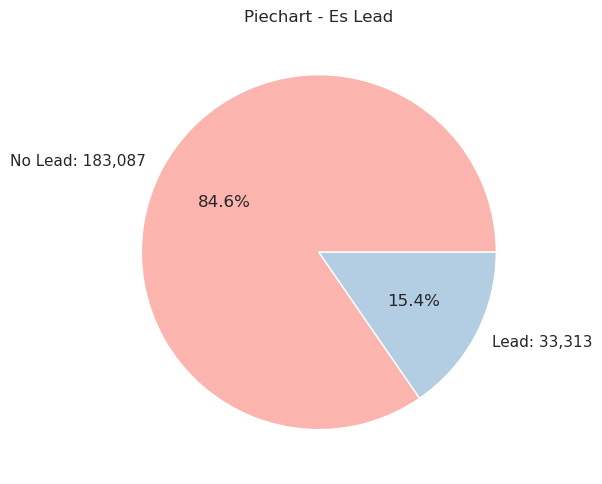

In [11]:
# ya que trabajaremos con clasificación, veamos cuántos casos hay de cada categoría:

fig, ax2 = plt.subplots(1, 1, figsize=(8, 5))
#sns.countplot(x=data.Is_Lead, ax=ax1)
#ax1.set_title('Countplot - Es Lead')
#for p in ax1.patches:
#    ax1.annotate(format(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
#                ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

create_piechart_with_values(data.Is_Lead, 'Piechart - Es Lead',ax2,['No Lead','Lead'])    

plt.tight_layout()
plt.show()


**Observaciones:**
    
Existe una desproporción muy grande entre las dos clases.

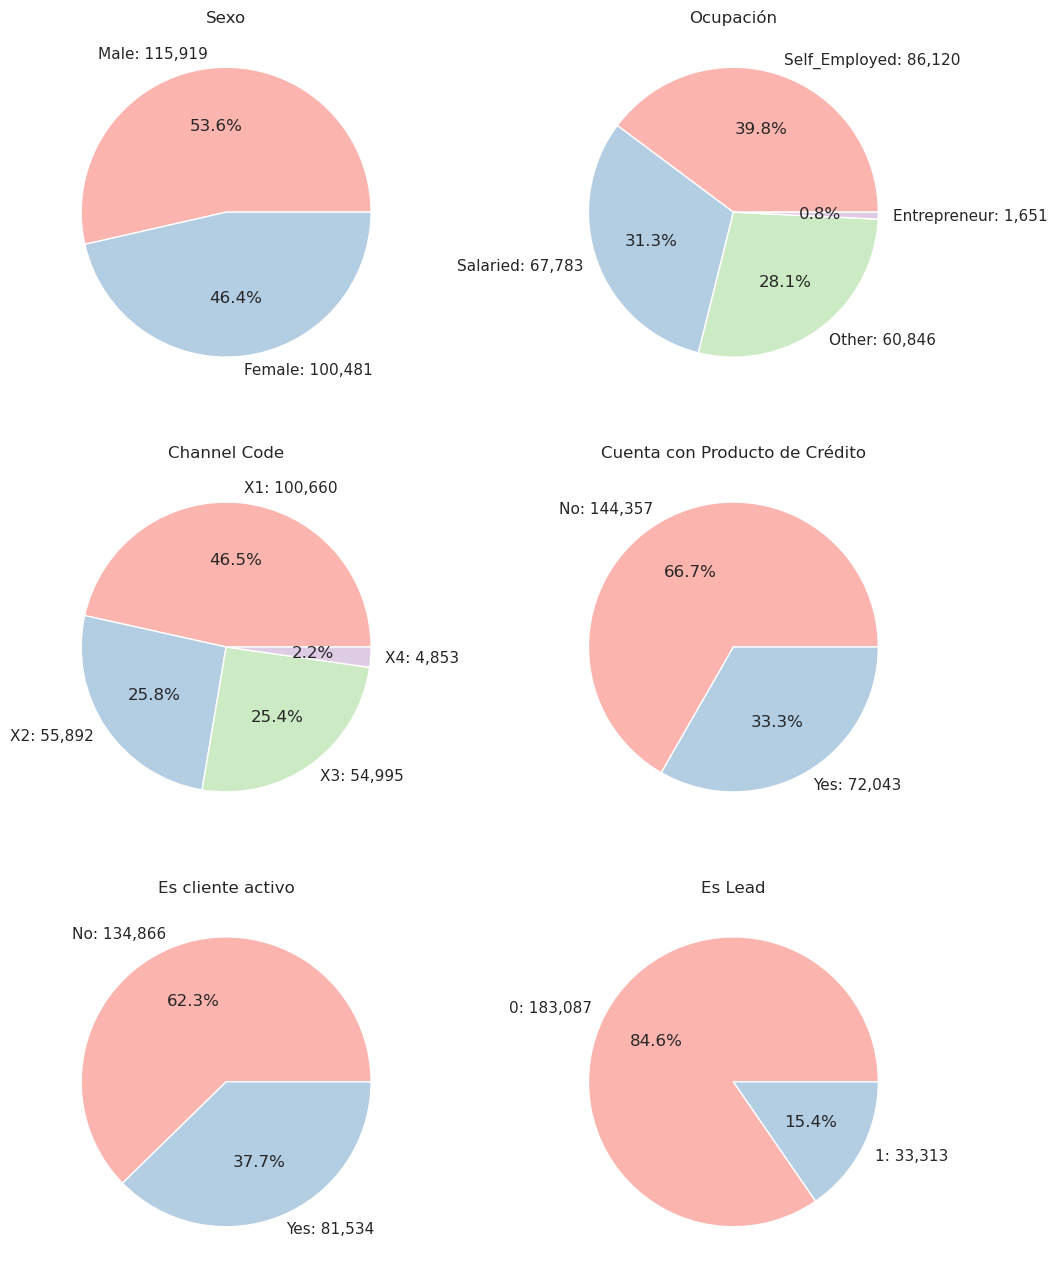

In [12]:
# Veamos las distribuciones de algunas variables:
fig, axes = plt.subplots(3, 2, figsize=(12, 16))

#sns.countplot(data=creditCardLeadDf, x='Gender', ax=axes[0])
#axes[0].set_title('Sexo')
#sns.countplot(data=creditCardLeadDf, x='Is_Active', ax=axes[0])
#axes[0].set_title('Es cliente activo')
#sns.countplot(data=creditCardLeadDf, x='Credit_Product', ax=axes[1])
#axes[1].set_title('Cuenta con Producto de Crédito')
#sns.countplot(data=creditCardLeadDf, x='Occupation', ax=axes[1])
#axes[1].set_title('Ocupación')

create_piechart_with_values(data.Gender, 'Sexo',axes[0][0])
create_piechart_with_values(data.Occupation, 'Ocupación',axes[0][1])
create_piechart_with_values(data.Channel_Code, 'Channel Code',axes[1][0])
create_piechart_with_values(data.Credit_Product, 'Cuenta con Producto de Crédito',axes[1][1])
create_piechart_with_values(data.Is_Active, 'Es cliente activo',axes[2][0])
create_piechart_with_values(data.Is_Lead, 'Es Lead',axes[2][1])

#plt.tight_layout()
plt.show()

Hay 35 valores distintos de Region_Code


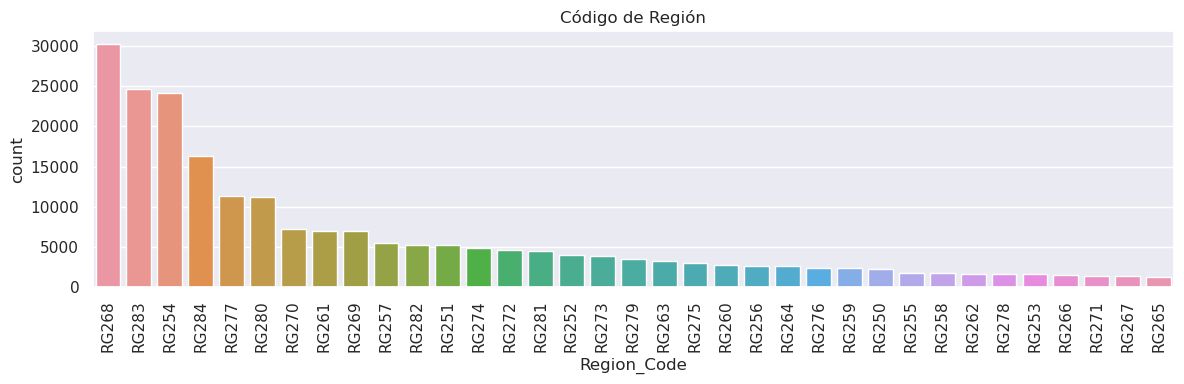

In [13]:
# Veamos las proporciones en algunas variables:
print('Hay',data.Region_Code.value_counts().shape[0],'valores distintos de Region_Code')

fig, axes = plt.subplots(1, 1, figsize=(12, 4))
sns.countplot(data=data.sort_values(by='Region_Code'), x='Region_Code', ax=axes, order = data['Region_Code'].value_counts().index)
axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
axes.set_title('Código de Región')
plt.tight_layout()

# Show the plot
plt.show()

**Observaciones:**

Más adelante podremos determinar si esta variable es relevante para la clasificación


#### Variables Numéricas

Veamos histogramas y boxplots para las variables numéricas que tienen nuestros datos

In [14]:
def createHist(data,titulo,nobins=None):
    fig, axes = plt.subplots(2, 1, figsize=(12, 4))
    #data = creditCardLeadDf['Avg_Account_Balance']
    #titulo = 'Balance Promedio'

    if nobins:
        sns.histplot(data,ax=axes[0],bins= (data.max()-data.min()) )
    else:
        sns.histplot(data,ax=axes[0] )
    axes[0].set_xlabel('Values')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title(titulo+' - Histograma')

    sns.boxplot(x=data, ax=axes[1])
    mean_value = np.mean(data)
    axes[1].plot(mean_value, 0,  marker='o', color='red', label='Mean')
    axes[1].text(mean_value+mean_value/1.5, -.3, f"Mean: {mean_value:.2f}", color='teal', ha='left', va='center')
    #axes[1].set_xlabel('Values')
    #axes[1].set_ylabel('Count')
    axes[1].set_title(titulo+' - Boxplot')
    #axes[1].legend()


    plt.tight_layout()
    plt.show()


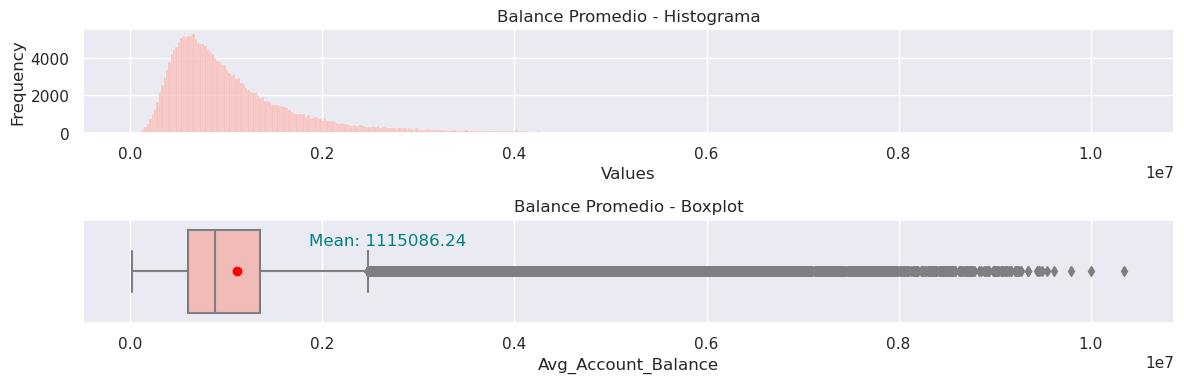

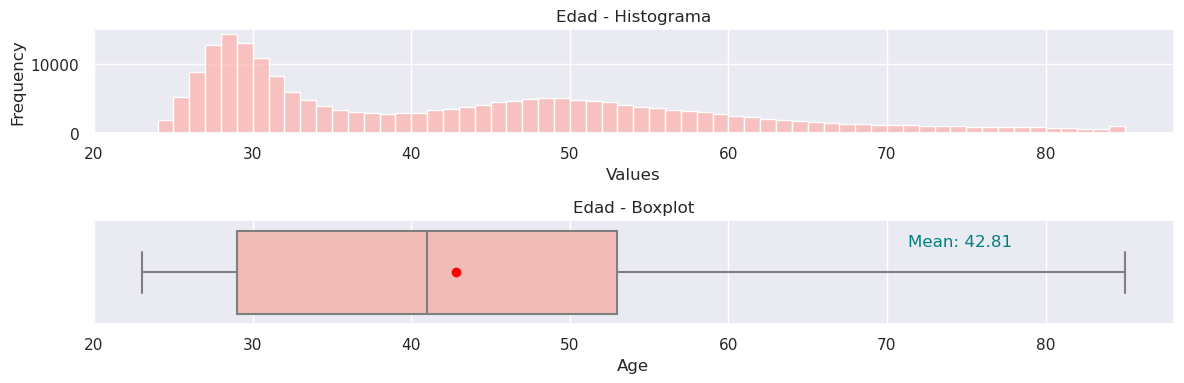

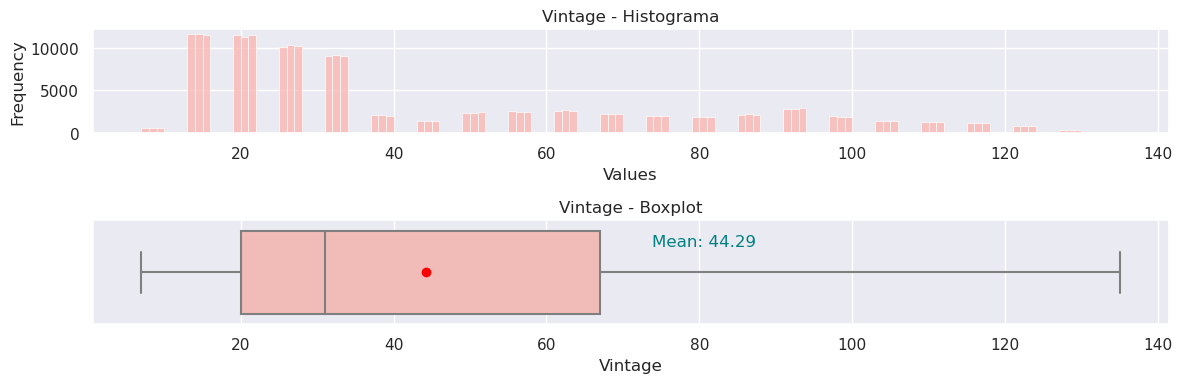

In [15]:
#sns.set_palette( palQualitative )
createHist(data['Avg_Account_Balance'],'Balance Promedio')
createHist(data['Age'],'Edad',nobins=True)
createHist(data['Vintage'],'Vintage',nobins=True)

In [16]:
# ya que la columna ID no aporta nada a la clasificación, la eliminaremos
data = data.drop('ID', axis=1)

In [17]:
data.head()

Gender  Age Region_Code     Occupation Channel_Code  Vintage  \
0  Female   73       RG268          Other           X3       43   
1  Female   30       RG277       Salaried           X1       32   
2  Female   56       RG268  Self_Employed           X3       26   
3    Male   34       RG270       Salaried           X1       19   
4  Female   30       RG282       Salaried           X1       33   

  Credit_Product  Avg_Account_Balance Is_Active  Is_Lead  
0             No              1045696        No        0  
1             No               581988        No        0  
2             No              1484315       Yes        0  
3             No               470454        No        0  
4             No               886787        No        0

#### Conversión de variables a one-hot encoding

Las siguientes columnas pueden ser codificadas como one-hot:

Gender (2 valores), Region_Code (35), Occupation (4), Channel_Code (4), Credit_Product (2), Is_Active (2)

In [19]:
# Codificamos en one-hot:
toOneHot = ['Gender', 'Occupation', 'Is_Active', 'Credit_Product','Channel_Code', 'Region_Code']
data = pd.get_dummies(data,columns=toOneHot)
print(data.shape)
display(data)

(216400, 53)


Age  Vintage  Avg_Account_Balance  Is_Lead  Gender_Female  \
0        73       43              1045696        0              1   
1        30       32               581988        0              1   
2        56       26              1484315        0              1   
3        34       19               470454        0              0   
4        30       33               886787        0              1   
...     ...      ...                  ...      ...            ...   
216395   38       13               354665        0              1   
216396   27       15               862952        0              0   
216397   26       13               670659        0              1   
216398   28       31               407504        0              1   
216399   29       21              1129276        0              0   

        Gender_Male  Occupation_Entrepreneur  Occupation_Other  \
0                 0                        0                 1   
1                 0                        0                 0   
2                 0                        0                 0   
3                 1                        0                 0   
4                 0                        0                 0   
...             ...                      ...               ...   
216395            0                        0                 0   
216396            1                        0                 0   
216397            0                        0                 0   
216398            0                        0                 0   
216399            1                        0                 0   

        Occupation_Salaried  Occupation_Self_Employed  ...  Region_Code_RG275  \
0                         0                         0  ...                  0   
1                         1                         0  ...                  0   
2                         0                         1  ...                  0   
3                         1                         0  ...                  0   
4                         1                         0  ...                  0   
...                     ...                       ...  ...                ...   
216395                    1                         0  ...                  0   
216396                    1                         0  ...                  0   
216397                    1                         0  ...                  0   
216398                    1                         0  ...                  0   
216399                    1                         0  ...                  0   

        Region_Code_RG276  Region_Code_RG277  Region_Code_RG278  \
0                       0                  0                  0   
1                       0                  1                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
216395                  0                  0                  0   
216396                  0                  0                  0   
216397                  0                  0                  0   
216398                  0                  0                  0   
216399                  0                  0                  0   

        Region_Code_RG279  Region_Code_RG280  Region_Code_RG281  \
0                       0                  0                  0   
1                       0                  0                  0   
2                       0                  0                  0   
3                       0                  0                  0   
4                       0                  0                  0   
...                   ...                ...                ...   
216395                  0                  1                  0   
216396                  0                  0                  0   
21639

#### Eliminación de variables innecesarias

In [20]:
# Para las variables que originalmente eran binarias, podemos eliminar una de sus
# dos columnas provenientes de get_dummies (Gender, Is_Active, ):
print(data.shape)
data = data.drop(['Gender_Female','Is_Active_No','Credit_Product_No'], axis=1)
print(data.shape)

(216400, 53)
(216400, 50)


#### Correlaciones entre variables y variables-salida

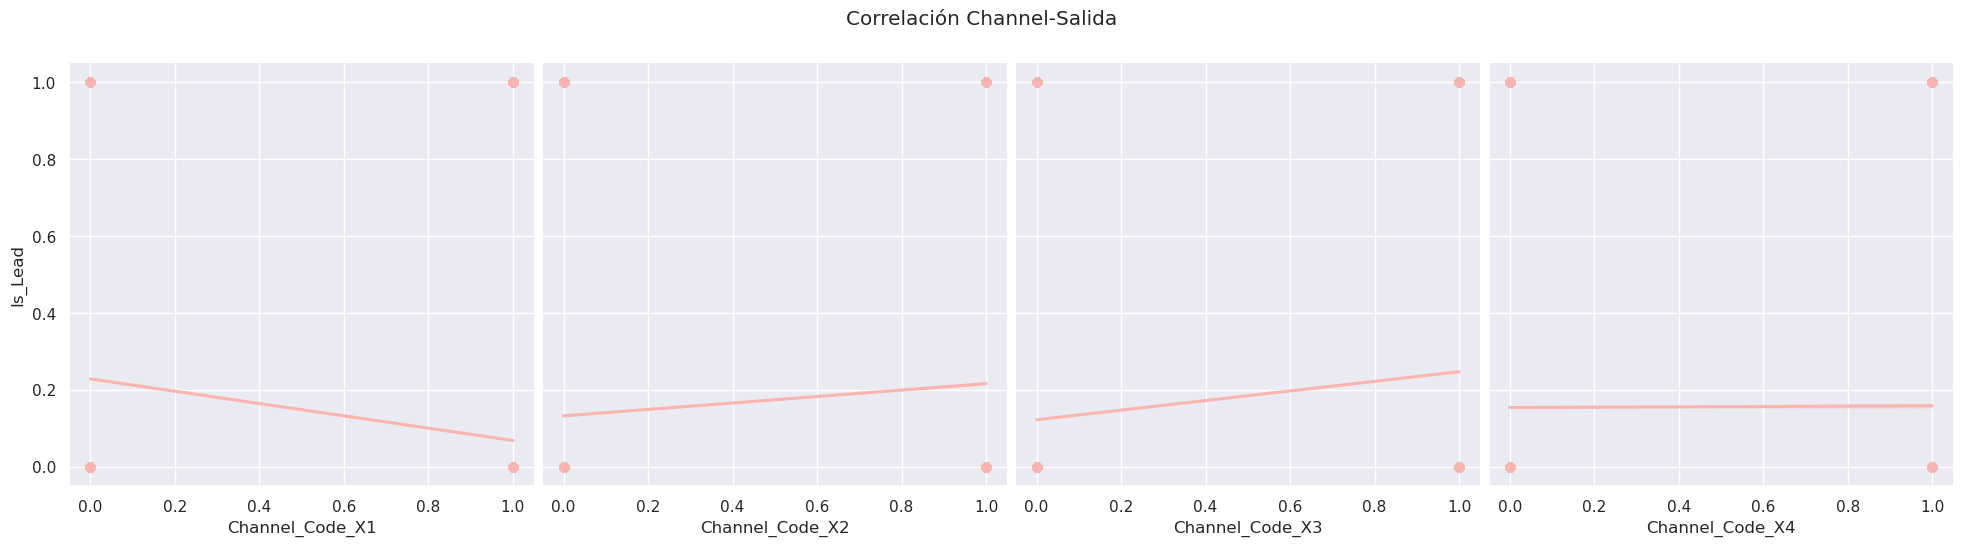

In [21]:
# Tratemos de ver correlación entre las variables de Channel_Code y la salida
x_vars = [ x for x in list(data) if 'Channel_Code' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Channel-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Parece que por lo menos las tres primeras sí tienen un efecto en la salida
# Aquí podría parecer que el chanel X4 es el menos efectivo obteniendo leads

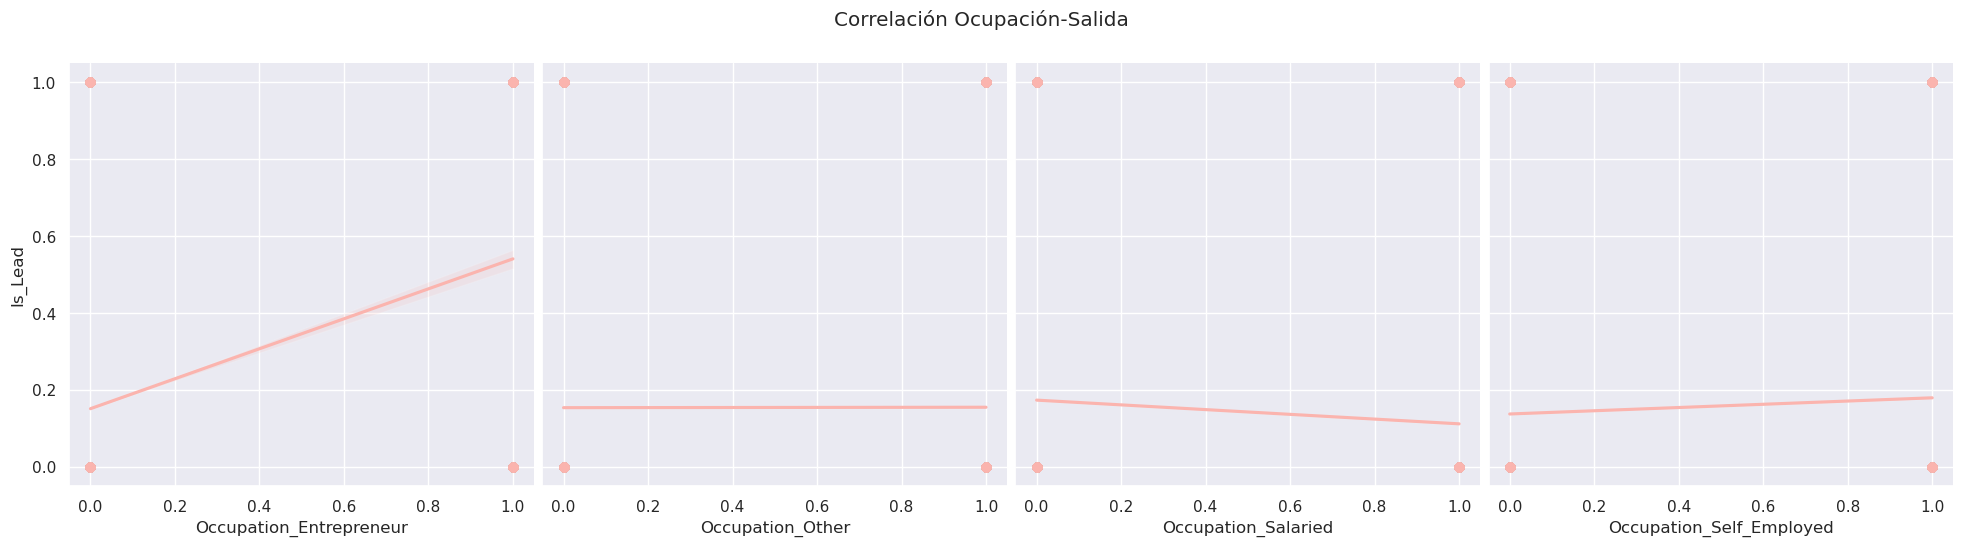

In [22]:
# Tratemos de ver correlación entre las variables de Occupation y la salida
x_vars = [ x for x in list(data) if 'Occupation' in x] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Ocupación-Salida', y=1.08)
    plt.show()

# Observaciones:    
# Vemos que de entre las 4, Occupation_Entrepreneur es la que tiene más efecto sobre la salida

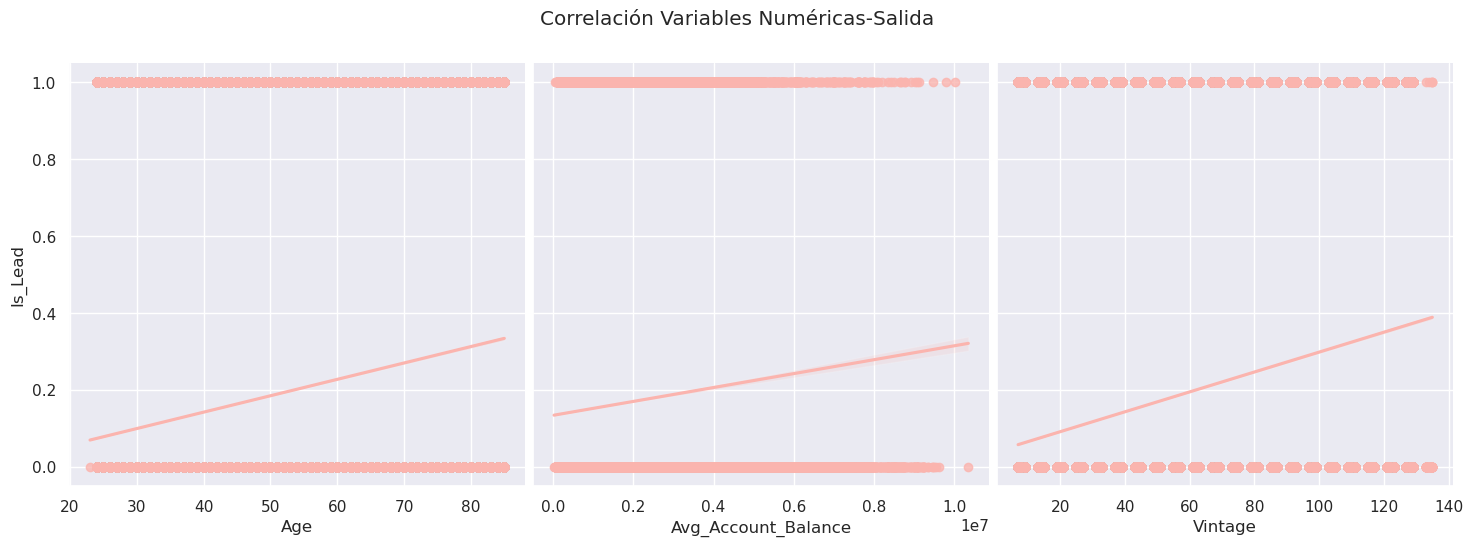

In [23]:
# Tratemos de ver correlación entre nuestras variables numéricas y la salida:
x_vars = ['Age','Avg_Account_Balance','Vintage'] 
graphsPerRow = len(x_vars)
assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'
for i in range(int(len(x_vars)/graphsPerRow)):
    if LONG_TIME_CELLS:
        graph = sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        graph.fig.suptitle('Correlación Variables Numéricas-Salida', y=1.08)
    plt.show()
    
# Observaciones:
# Vemos que de las tres tienen cierto grado apreciable de correlación con la salida

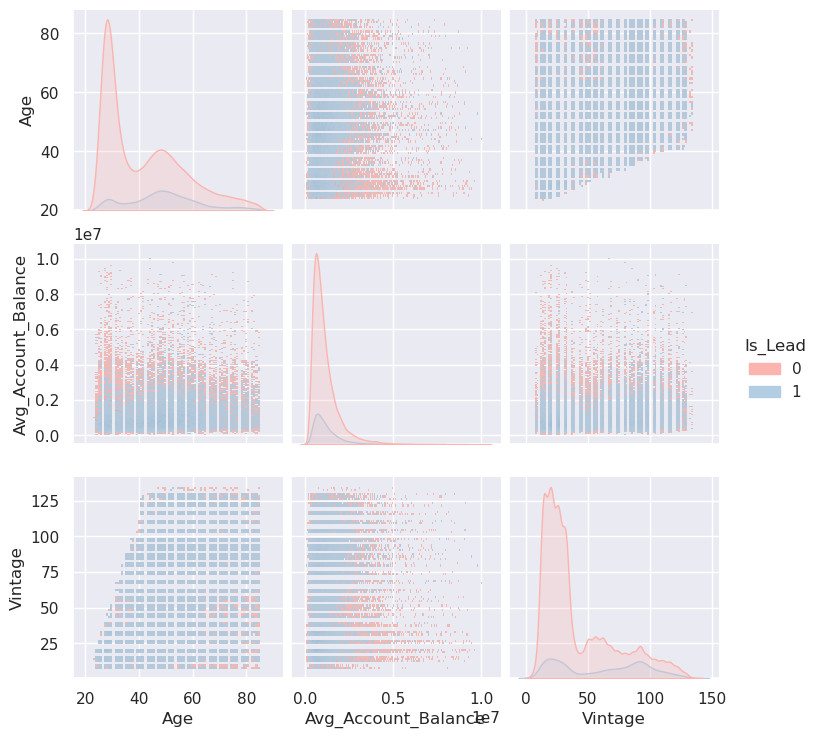

In [24]:
# Y ahora veamos la correclación entre esas tres variables
#sns.pairplot(data, vars=x_vars, hue='Is_Lead', markers = ['d','v'], kind = "hist", diag_kind = None)
if LONG_TIME_CELLS:
    sns.pairplot(data, vars=x_vars, hue='Is_Lead', kind = "hist", diag_kind = 'kde')

# Observaciones:
# No encotramos mucha correlación entre éstas

In [25]:
# También vemos la correlación entre estas variables usando Spearman
display(data[x_vars].corr(method="spearman"))

# Observaciones:
# Se observa una correlación significativa entre Age y Vintage, lo cual es de esperarse porque
# sólo la gente de mayor edad puede tener más historial crediticio
# (Yo esperaba encontrar más correlación entre edad y balance)

Age  Avg_Account_Balance   Vintage
Age                  1.000000             0.168859  0.655250
Avg_Account_Balance  0.168859             1.000000  0.184243
Vintage              0.655250             0.184243  1.000000

**Observaciones:**
    
Age y Vintage tienen correlación moderada.

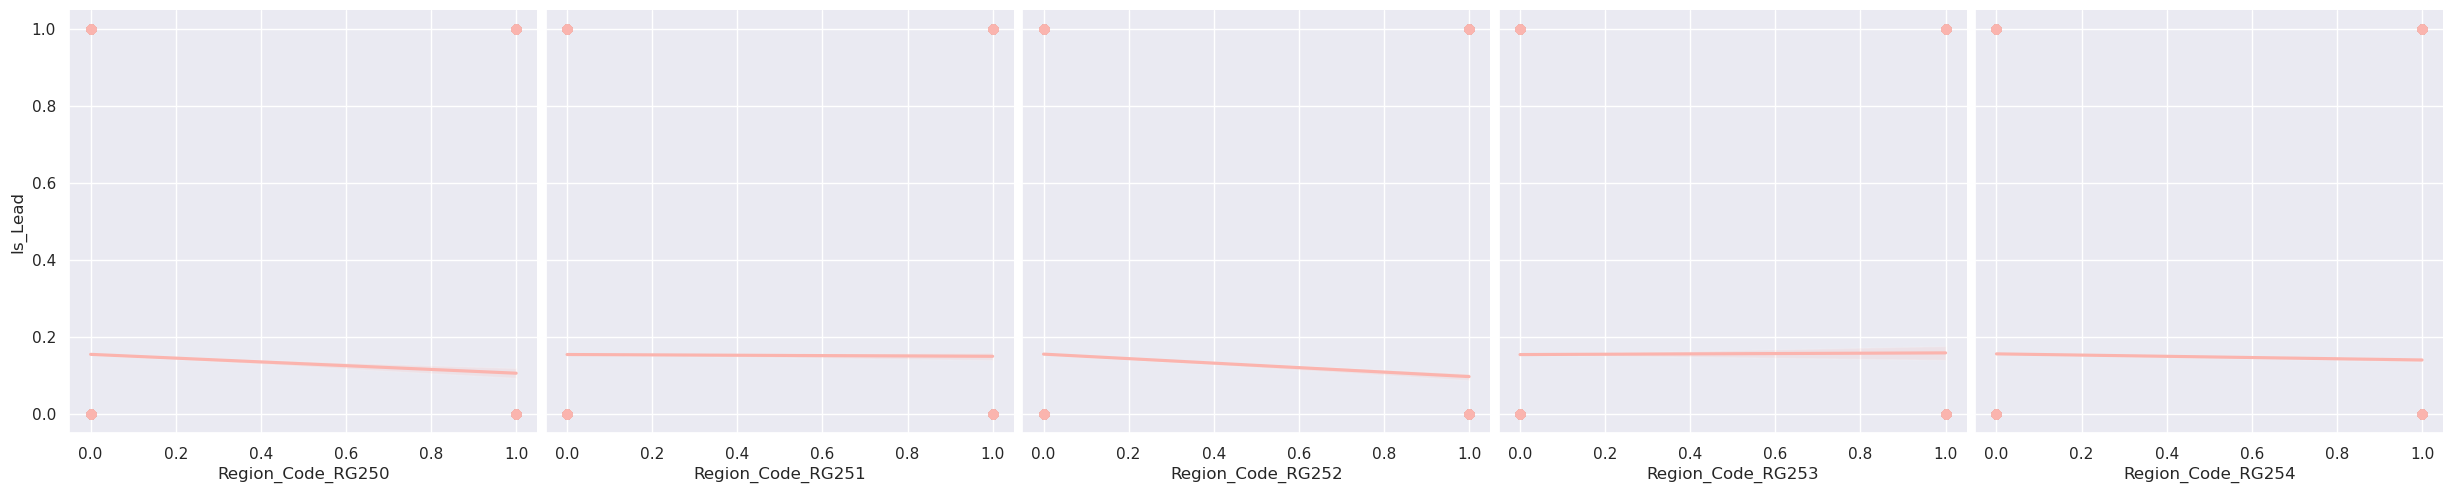

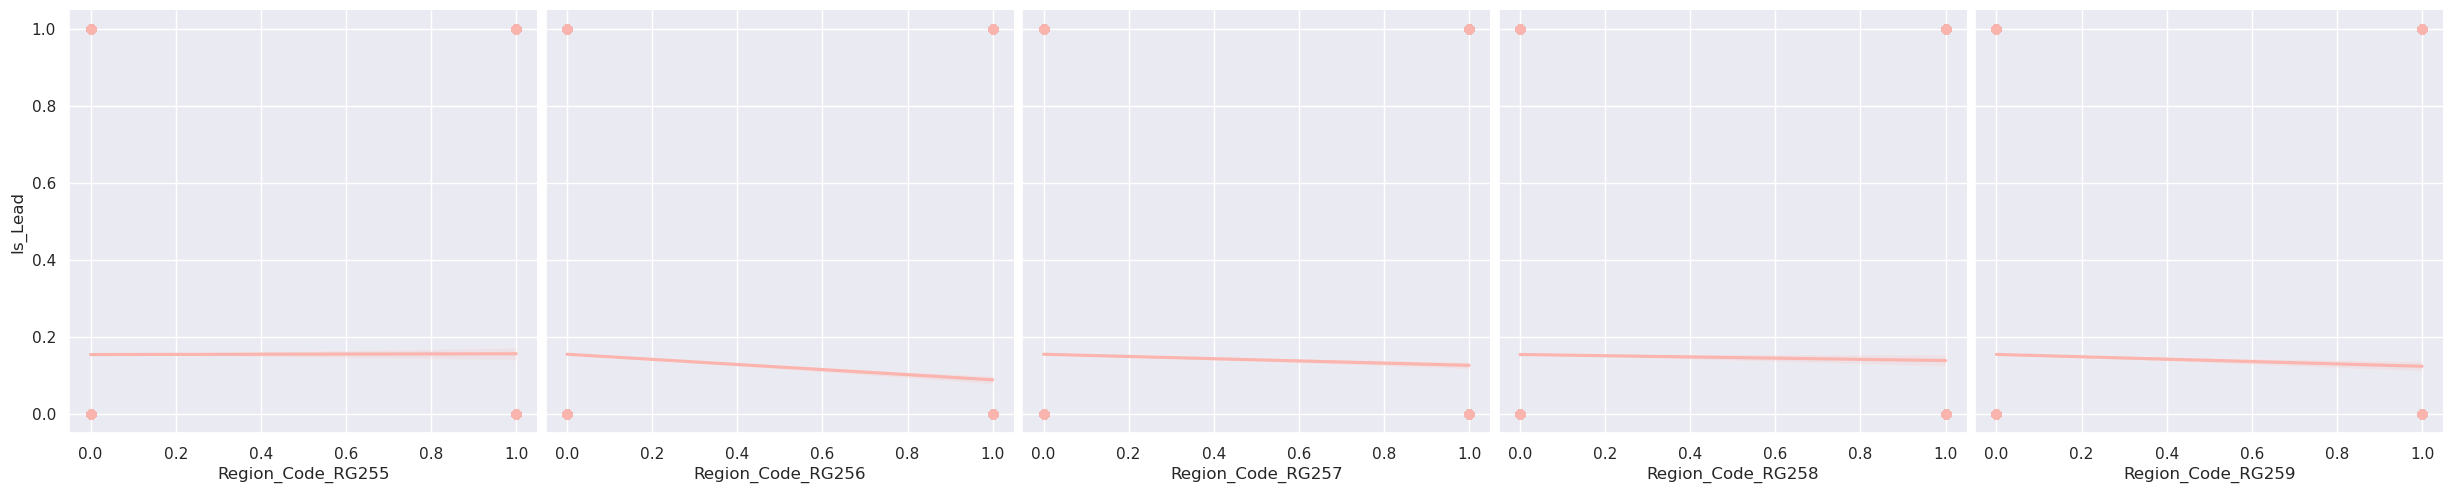

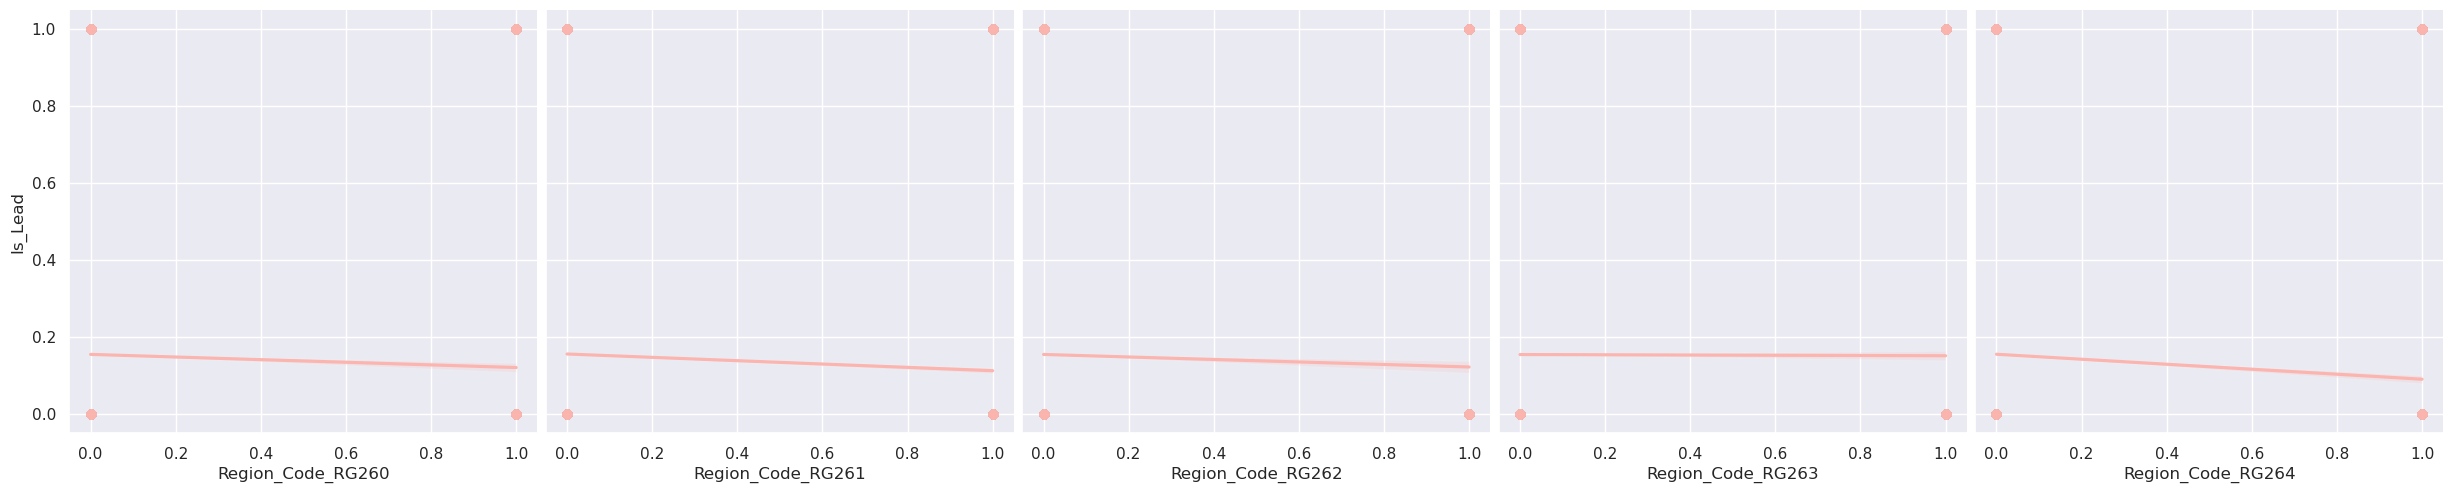

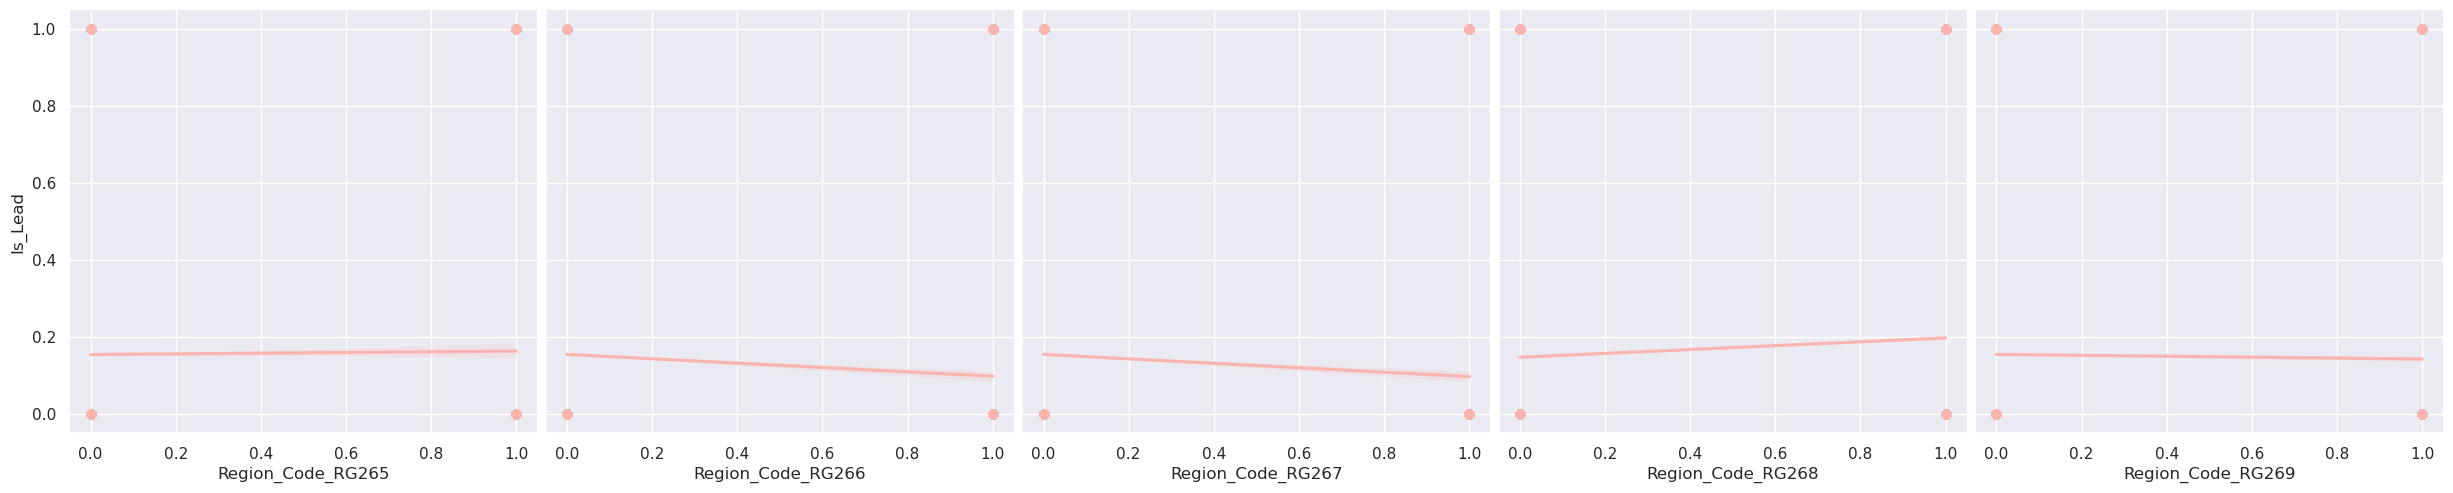

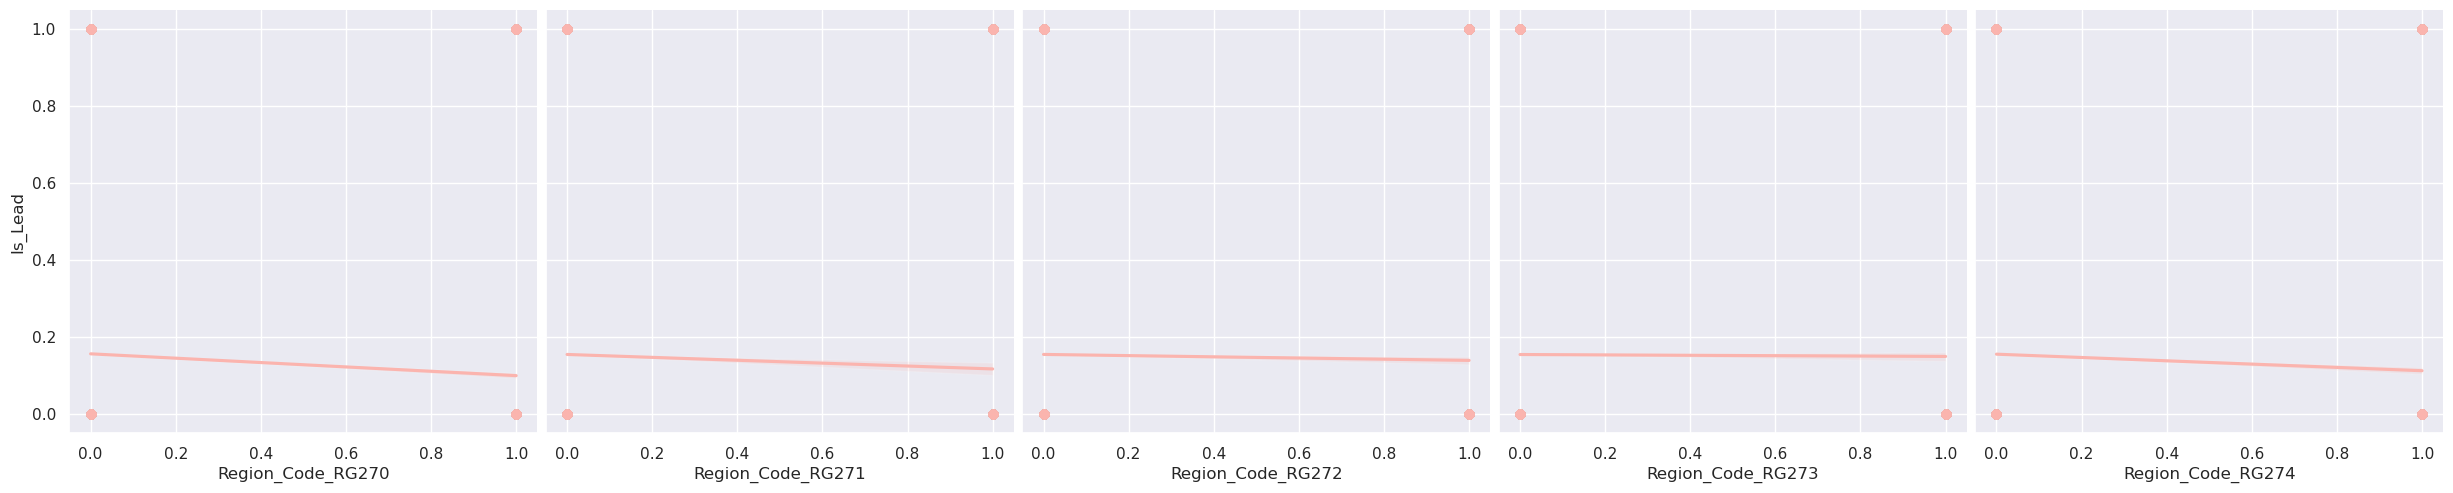

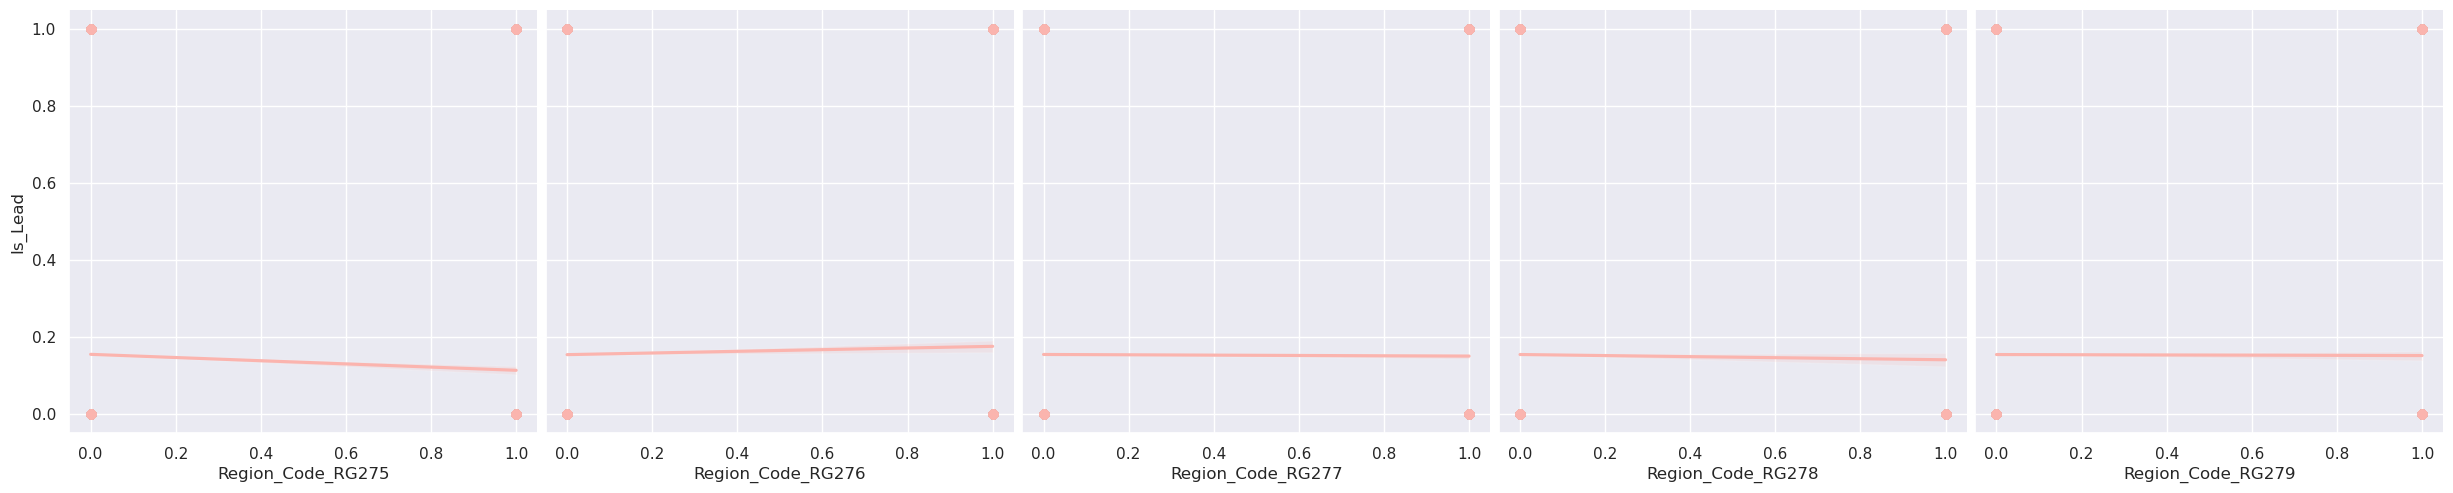

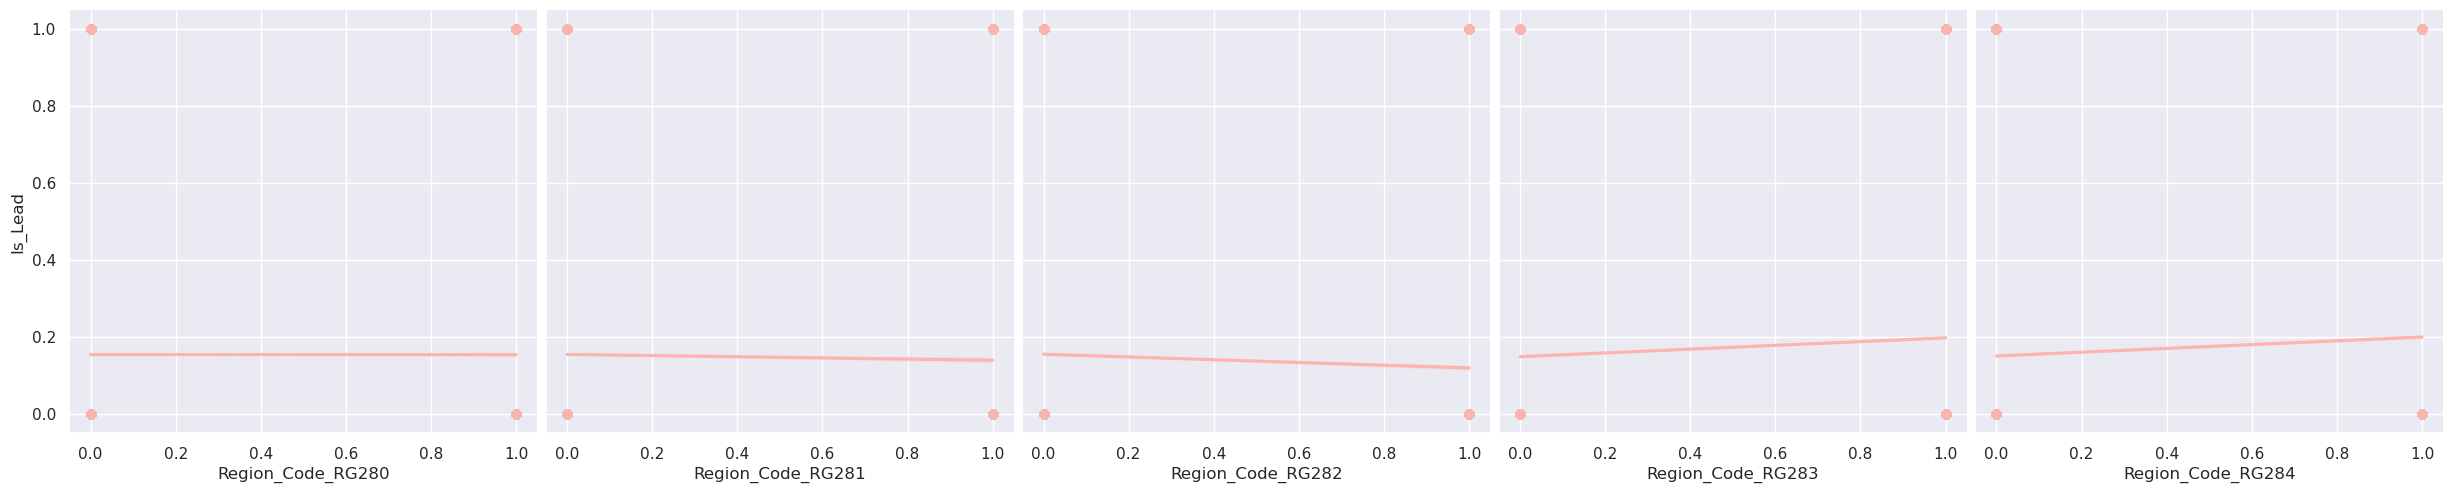

In [26]:
# Tratemos de ver correlaciones entre las variables de región y la salida
x_vars = list(data)
x_vars = [ x for x in x_vars if 'Region' in x] 

#print(x_vars)
#print(len(x_vars))

graphsPerRow = 5

assert len(x_vars) % graphsPerRow == 0,f'usa un múltiplo de {len(x_vars)} para el número de gráficas por fila'

if LONG_TIME_CELLS:
    for i in range(int(len(x_vars)/graphsPerRow)):
        sns.pairplot(data, x_vars=x_vars[i*graphsPerRow:i*graphsPerRow+graphsPerRow], y_vars='Is_Lead', height=5, aspect=1, kind='reg')
        plt.show()

# Observaciones:
# No notamos que alguna región destaque

In [27]:
# Veamos si hay otras correlaciones entre nuestras variables:
thres = .4
corrs = data.corr(method="spearman")
print(f'Spearman > {thres}:')
print(f'-------------------------')
moreCorr = []
for i, row in corrs.iterrows():
    for ic,val in zip(list(data),row):
        if val>thres and i!=ic:
            if val>=.4 and val<.69:
                note = 'Correlación moderada'
            elif val>.7 and val<.89:
                note = 'Correlación fuerte'
            elif val>=.9:
                note = 'Correlación muy fuerte'
                
            variablesCorrelacionadas = [i,ic]
            variablesCorrelacionadas.sort()
            text = ' - '.join(variablesCorrelacionadas)
            moreCorr.append(f' {text} : {str(round(val,3))} ({note})')

moreCorr=list(set(moreCorr))
moreCorr.sort()
for i in moreCorr:
    print(i)

Spearman > 0.4:
-------------------------
 Age - Channel_Code_X3 : 0.474 (Correlación moderada)
 Age - Vintage : 0.655 (Correlación moderada)
 Channel_Code_X1 - Occupation_Salaried : 0.603 (Correlación moderada)
 Channel_Code_X3 - Vintage : 0.484 (Correlación moderada)


**Observaciones:**

Se nota una correlación moderada entre Channel_Code_X3 y  Vintage (pudo ser que ese canal se enfocó en ciertos clientes con mucha o poca antiguedad).

También moderada de ese mismo canal y la edad de los clientes.

Y correlaciones un poco más fuertes entre el canal X1 y clientes asalariados.

Desde luego, la correlación que ya habiamos notado entre edad y vintage (historial crediticio).

#### Preparación de datos para los modelos

In [28]:
dataFull = data.copy()
X_full = dataFull.drop('Is_Lead',axis=1)
y_full = dataFull['Is_Lead']

In [29]:
# Ejecutar desde aquí para diferentes pruebas con fracciones de los datos originales
data = dataFull.sample(frac=DATA_FRACTION)
data.reset_index(inplace=True,drop=True)

print("Fracción de datos utlizados para entrenamiento:", DATA_FRACTION*100,'%')
print('Train Data size:',data.shape)
print('Full Data size:',dataFull.shape)

Fracción de datos utlizados para entrenamiento: 100 %
Train Data size: (216400, 50)
Full Data size: (216400, 50)


#### Primer splitting para entrenar

In [30]:
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']

### Exploración de selección de features con SelectKBest

In [31]:
# Selección de Features con Threshold fue descartada debido al alto número de variables categpóicas
best=10
selector = SelectKBest(k=best,score_func=chi2)

#scaler = MinMaxScaler()
#XScaled = scaler.fit_transform(X)
#XScaled = pd.DataFrame(data=XScaled, columns=list(X))

selector.fit(X,y)
print(f'Las {best} mejores features son:')
for col in selector.get_feature_names_out():
    print(f'   {col}')


Las 10 mejores features son:
   Age
   Vintage
   Avg_Account_Balance
   Occupation_Entrepreneur
   Occupation_Salaried
   Is_Active_Yes
   Credit_Product_Yes
   Channel_Code_X1
   Channel_Code_X2
   Channel_Code_X3


**Observaciones:**

Para KBest usamos la distrución chi2 que es recomendada para cuando se cuenta con variables categóricas.

Las 3 variables numéricas son las más importantes de acuerdo al selector. También confirmamos que de las variables categóricas, Occupation_Entrepreneur juega el papel más importante importante.

### Clasificación con árboles de decisión

#### Arboles de decisión con datos originales (1/3)

In [32]:
# dataframe para guardar performace metrics
treesPerformances = pd.DataFrame(columns=['Data', 'Acc','Recall','Precision', 'F1'])

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

In [34]:
# guardemos X_test y_test originales para usarlos en los dos árboles finales:
X_test_original = X_test.copy()
y_test_original = y_test.copy()

In [35]:
importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

importancia
feature                         
Avg_Account_Balance        0.309
Vintage                    0.154
Age                        0.151
Credit_Product_Yes         0.099
Occupation_Salaried        0.028
Gender_Male                0.026
Is_Active_Yes              0.023
Region_Code_RG283          0.015
Region_Code_RG268          0.015
Channel_Code_X3            0.012

Accuracy: 0.793
Recall: 0.355
Precision: 0.339


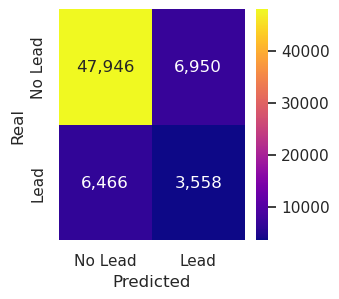

In [36]:
pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Datos originales', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()

**Observaciones:**
    
Al parecer el hecho de que los ejemplos están desbalanceados affecta el desempeño del modelo. A continuación balancearemos los ejemplos por medio de sub/over sampling.


#### Árboles de decisión con datos submuestreados  (1/2)

In [37]:
import imblearn

#Submuestreo

# lista los índices de Is_Lead
lead_idxs = data[data["Is_Lead"]==1].index.to_list()
print('Is_Lead == 1: ',len(lead_idxs))

# lista de índices que no son lead
nolead_idxs = data[data["Is_Lead"]==0].index.to_list()
print('Is_Lead == 0: ',len(nolead_idxs))

# seleccionamos aleatoriamente el doble de índices de no leads
random_nolead_idxs = np.random.choice(nolead_idxs, int(len(lead_idxs)*1.5), replace= False)
print('random picks len:',len(random_nolead_idxs))

# concatenamos los índices fraudulentos y normales y creamos el dataframe sub-sampleado
undersampled_indices = np.concatenate([lead_idxs, random_nolead_idxs])
undersampled_data = data.iloc[undersampled_indices,:]

print(f"Lead: {len(lead_idxs)}, No Lead: {len(random_nolead_idxs)}")

print(f'Tamaño de data sin resampling: {data.shape}')
print(f'Tamaño de data luego de resampling: {undersampled_data.shape}')

Is_Lead == 1:  33313
Is_Lead == 0:  183087
random picks len: 49969
Lead: 33313, Normales: 49969
Tamaño de data sin resampling: (216400, 50)
Tamaño de data luego de resampling: (83282, 50)


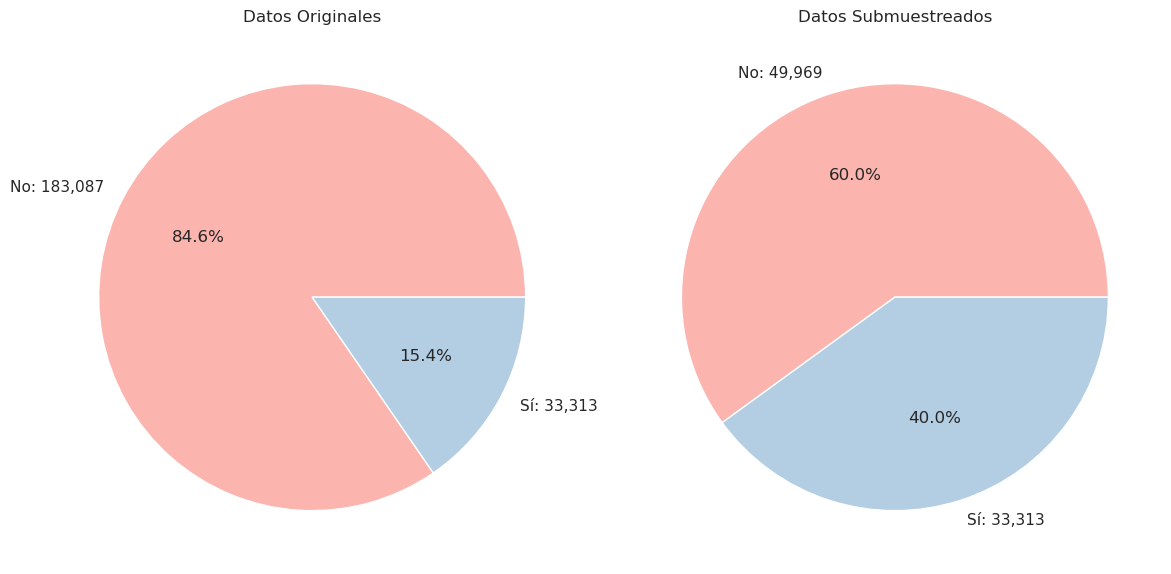

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

create_piechart_with_values(data.Is_Lead, 'Datos Originales',ax1,['No','Sí'])    
create_piechart_with_values(undersampled_data.Is_Lead, 'Datos Submuestreados',ax2,['No','Sí'])    

plt.tight_layout()
plt.show()

In [39]:
# "backup de data"
dataBkup = data.copy()

importancia
feature                         
Avg_Account_Balance        0.260
Credit_Product_Yes         0.167
Age                        0.161
Vintage                    0.140
Gender_Male                0.025
Is_Active_Yes              0.021
Occupation_Salaried        0.016
Region_Code_RG283          0.015
Region_Code_RG268          0.014
Region_Code_RG254          0.013

Accuracy: 0.654
Recall: 0.575
Precision: 0.565


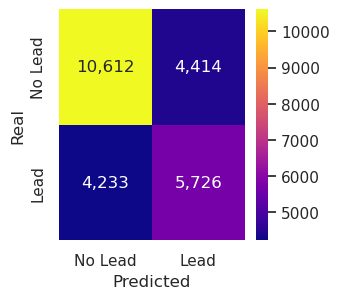

In [40]:
X = undersampled_data.drop('Is_Lead',axis=1)
y = undersampled_data['Is_Lead']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df para metricas (haremos otro test con los datos originales, no los submuestreados)
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



importancia
feature                         
Avg_Account_Balance        0.260
Credit_Product_Yes         0.167
Age                        0.161
Vintage                    0.140
Gender_Male                0.025
Is_Active_Yes              0.021
Occupation_Salaried        0.016
Region_Code_RG283          0.015
Region_Code_RG268          0.014
Region_Code_RG254          0.013

Accuracy: 0.78
Recall: 0.875
Precision: 0.403


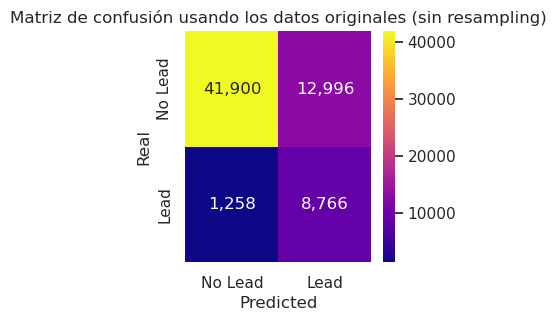

In [41]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sub-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

#### Árboles de decisión con oversampling  (3/3)

In [42]:
# restauramos data
data=dataBkup.copy()

from collections import Counter

print('Datos de entrada a SMOTE:',data.shape)

oversample = SMOTE()

X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_oversampled, y_oversampled = oversample.fit_resample(X, y)
print(Counter(y_oversampled))

print("Datos SMOTE originales X, y:", X_oversampled.shape,y_oversampled.shape)

# lista los índices sampleados
smoteSampleIdxs = X_oversampled.index.to_list()
print('smoteSampleIdx lenght:',len(smoteSampleIdxs))
randomSmoteSampleIdxs = np.random.choice(smoteSampleIdxs, int(len(smoteSampleIdxs)*SMOTE_FRACTION), replace= False)
X_oversampled = X_oversampled.iloc[randomSmoteSampleIdxs,:]
y_oversampled = y_oversampled.iloc[randomSmoteSampleIdxs]

print("Fracción de datos SMOTE utlizados:", SMOTE_FRACTION*100,'%')
print(f"Matriz de features: {X_oversampled.shape}")
print(f"Matriz de etiquetas: {y_oversampled.shape}")


print(Counter(y_oversampled))

Datos de entrada a SMOTE: (216400, 50)
Counter({0: 183087, 1: 183087})
Datos SMOTE originales X, y: (366174, 49) (366174,)
smoteSampleIdx lenght: 366174
Fracción de datos SMOTE utlizados: 50.0 %
Matriz de features: (183087, 49)
Matriz de etiquetas: (183087,)
Counter({1: 91573, 0: 91514})


importancia
feature                              
Channel_Code_X1                 0.226
Avg_Account_Balance             0.129
Occupation_Other                0.118
Occupation_Self_Employed        0.104
Vintage                         0.086
Age                             0.070
Channel_Code_X3                 0.048
Channel_Code_X2                 0.030
Channel_Code_X4                 0.027
Is_Active_Yes                   0.026

Accuracy: 0.851
Recall: 0.86
Precision: 0.844


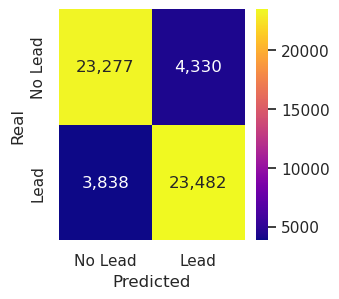

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3) # 70% training and 30% test

clf = DecisionTreeClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test,y_pred),3)
pmRecall=round(recall_score(y_test,y_pred),3)
pmPrecision=round(precision_score(y_test,y_pred),3)
pmF1=round(f1_score(y_test, y_pred),3)
# no guardamos en df de metricas, más adelante probaremos con los datos originales, no los sobremuestreados
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.show()



In [44]:
# falta visualización
viz = model(clf,
        tree_index=3,
        X_train=X_train,
        y_train=y_train,
        feature_names=list(X_train),
        target_name='Lead',
        class_names=['Lead','No Lead']
)

if LONG_TIME_CELLS:
    # no funciona
    # viz.view(scale=1.2,fontname='DejaVu Sans')
    pass


In [45]:
text_representation = tree.export_text(decision_tree=clf)
print(X_train.columns[9])
print(text_representation)


Credit_Product_Yes
|--- feature_10 <= 0.50
|   |--- feature_7 <= 0.50
|   |   |--- feature_5 <= 0.50
|   |   |   |--- feature_6 <= 0.50
|   |   |   |   |--- feature_4 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- feature_4 >  0.50
|   |   |   |   |   |--- feature_1 <= 62.50
|   |   |   |   |   |   |--- feature_8 <= 0.50
|   |   |   |   |   |   |   |--- feature_2 <= 782754.50
|   |   |   |   |   |   |   |   |--- feature_1 <= 19.50
|   |   |   |   |   |   |   |   |   |--- feature_38 <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- feature_15 <= 0.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |   |--- feature_15 >  0.50
|   |   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |   |--- feature_38 >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |   |   |--- feature_1 >  19.50
|   |   |   |   |   |   |   |   |   |--- feature_0 <= 51

In [46]:
# falta visualización
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = list(X),class_names=['No Lead','Lead'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png('cardleads-tree.png')
#Image(graph.create_png())

importancia
feature                              
Channel_Code_X1                 0.226
Avg_Account_Balance             0.129
Occupation_Other                0.118
Occupation_Self_Employed        0.104
Vintage                         0.086
Age                             0.070
Channel_Code_X3                 0.048
Channel_Code_X2                 0.030
Channel_Code_X4                 0.027
Is_Active_Yes                   0.026

Accuracy: 0.852
Recall: 0.605
Precision: 0.519


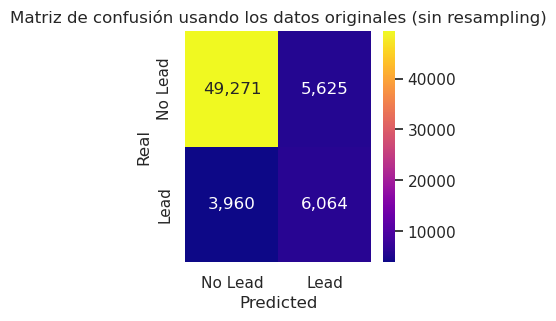

In [47]:
# test con los datos de prueba originales:
y_pred = clf.predict(X_test_original)

importances_df = pd.DataFrame({'feature':list(X),'importancia':np.round(clf.feature_importances_,3)})
importances_df.sort_values(by='importancia',ascending=False,inplace=True)
display(importances_df.set_index('feature').head(10))

pmAccuracy=round(accuracy_score(y_test_original,y_pred),3)
pmRecall=round(recall_score(y_test_original,y_pred),3)
pmPrecision=round(precision_score(y_test_original,y_pred),3)
pmF1=round(f1_score(y_test_original, y_pred),3)
treesPerformances.loc[len(treesPerformances.index)] = ['Sobre-muestreo', pmAccuracy, pmRecall, pmPrecision, pmF1 ] 
print(f"Accuracy: {pmAccuracy}")
print(f"Recall: {pmRecall}")
print(f"Precision: {pmPrecision}")

target_labels = ['No Lead','Lead']
plt.figure(figsize=(3,3))
cm = confusion_matrix(y_test_original,y_pred)
ax = sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',
            xticklabels=target_labels,
            yticklabels=target_labels)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
plt.title('Matriz de confusión usando los datos originales (sin resampling)')    
plt.show()

#### Comparación de métricas de rendimiento para los árboles de decisión usando modelos entrenados con diferentes sets de datos, probados todos con los datos originales

In [48]:
display(treesPerformances.sort_values(by='Acc', ascending=False))

Data    Acc  Recall  Precision     F1
2    Sobre-muestreo  0.852   0.605      0.519  0.559
0  Datos originales  0.793   0.355      0.339  0.347
1      Sub-muestreo  0.780   0.875      0.403  0.552

### Exploración de componentes pricipales

Train data antes de reducción de dimensionalidad: (216400, 49)
Train data luego de reducción de dimensionalidad: (216400, 25)
El 70.0% de la varianza se obtiene con 7 componentes principales



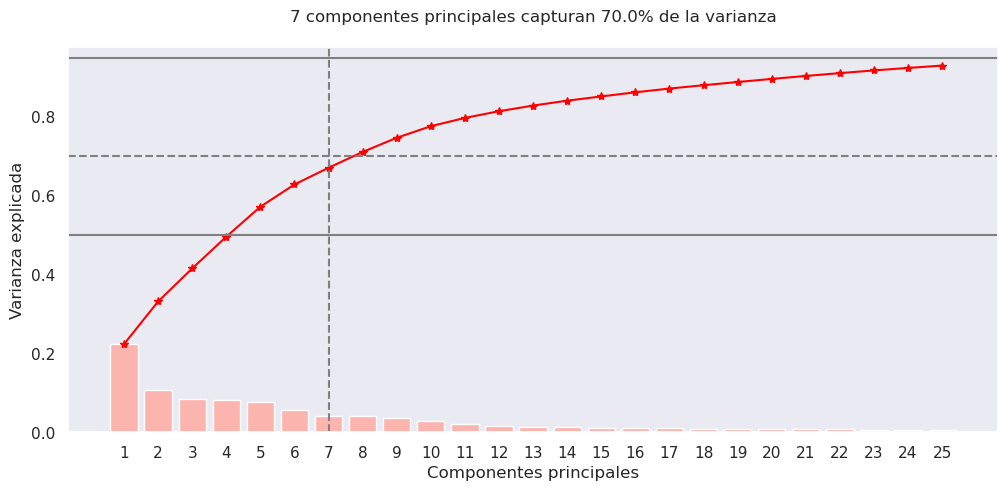

In [49]:
# restauramos data
data=dataBkup.copy()
X = data.drop('Is_Lead',axis=1)
y = data['Is_Lead']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=25)
X_red = pca.fit_transform(X_scaled)
#X_challenge_red = pca.transform(X_challenge_scaled)

print('Train data antes de reducción de dimensionalidad:',X.shape)
print('Train data luego de reducción de dimensionalidad:',X_red.shape)
#print('Test data luego de reducción de dimensionalidad:',X_challenge_red.shape)

xs = list(range(1, pca.explained_variance_ratio_.shape[0]+1))
capturedVarThreshold = .70

plt.figure(figsize=(12,5))
plt.bar(xs, pca.explained_variance_ratio_)
plt.xticks(xs)
plt.plot(xs, np.cumsum(pca.explained_variance_ratio_), '-*',color='red')
plt.grid()
plt.xlabel("Componentes principales")
plt.ylabel("Varianza explicada")

captured = np.cumsum(pca.explained_variance_ratio_)
#print(f"Varianza explicada por cada una de las componentes principales:\n{pca.explained_variance_ratio_}\n")
#print(f"Varianza acumulada explicada por cada una de las componentes principales:\n{captured)}\n")

plt.axhline(.5,color='gray',linestyle='-')
plt.axhline(.95,color='gray',linestyle='-')

maxPC = np.where(captured >= capturedVarThreshold)[0][0]
plt.axhline(capturedVarThreshold,color='gray',linestyle='--')
plt.axvline(maxPC,color='gray',linestyle='--')
#plt.xticks(rotation=80)

plt.title(f"{maxPC} componentes principales capturan {capturedVarThreshold*100}% de la varianza\n")

print(f"El {capturedVarThreshold*100}% de la varianza se obtiene con {maxPC} componentes principales\n")

### Preparación de pipeline y grid search para prueba de múltiples clasificadores con múltiples hiperparámetros

Usaremos los datos ~~submuestreados~~ sobremuestreados.

In [50]:
if DATA_TO_USE == 'over':
    X_train, X_test, y_train, y_test = train_test_split(X_oversampled, y_oversampled, test_size=0.3, random_state=101) # 70% training and 30% test
    X = X_oversampled
    y = y_oversampled
elif DATA_TO_USE == 'sub':
    X = undersampled_data.drop('Is_Lead',axis=1)
    y = undersampled_data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test
elif DATA_TO_USE == 'orig':
    data = dataBkup.copy()
    X = data.drop('Is_Lead',axis=1)
    y = data['Is_Lead']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101) # 70% training and 30% test

print(f"Usando data: {DATA_TO_USE}")    
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

Usando data: over
X_train: 128,160, X_test: 54,927, y_train: 128,160, y_test: 54,927


In [51]:
# dataframe para guardar performace metrics
classifiersPerformances = pd.DataFrame(columns=['Classifier','Data',
                                                'Acc','Recall','Precision','F1','Roc-Auc',
                                               ])

In [52]:
SCALER = True
POLY = False
DIMRED = True # si no hacemos dimRed el fitting toma demasiado tiempo
PCA_COMPONENTS = maxPC 

# CLASSIFIER /////////////////////(editar para cambiar el clasificador)/////////////////////
#classifier = RandomForestClassifier(n_jobs=-1)
classifier = SVC(probability=True)
#classifier =  RidgeClassifier()

# SCALER OBJECT
scaler = MinMaxScaler() if SCALER else None
#scaler = StandardScaler()

# POLYNOMIAL FEATURES OBJECT
poly = PolynomialFeatures(include_bias=True) if POLY else None

# DIMENSIONALITY REDUCTION OBJECT
dimRed = PCA(n_components=PCA_COMPONENTS) if DIMRED else None

# parámetros a probar con grid search:

# params for SVM:
#if type(classifier) == type(SVC()):
#    gridParams = [
#        {
#            'classifier__C': [.01,.1, 1, 10, 100, 1000],
#            'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#            'classifier__gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
#            'poly__degree': [1,2,3]
#        },
#    ]
    

# Larger C values (e.g., 1, 10, 100) can be useful when:
#  The dataset is clean and has limited noise.
#  You want to capture complex decision boundaries.
#  You are willing to tolerate some misclassifications.

# Smaller gamma values (e.g., 0.001, 0.01) can be useful when:
#  The dataset is large.
#  The decision boundary is expected to be relatively smooth.
#  The classes are well-separated and the data is not too complex.

# params for SVM:
if type(classifier) == type(SVC()):
    gridParams = [
        {
            'classifier__C': [5, 10, 50,100],
            'classifier__kernel': ['poly', 'rbf', 'sigmoid'],
            'classifier__gamma': [.001,0.1, 0.5, .1],
            'poly__degree': [1,3]
        },
    ]

# params for RandomForest:
if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    gridParams = [
        {
            'classifier__n_estimators':[10,50,100]
        }]
    
# params for Linear(Ridge):
if type(classifier) == type(RidgeClassifier()):
    gridParams = [{
        'classifier__alpha':[.01,.1, 1,5,10],
    }]

# quitamos los parámetros que no se utilizarán
newParams = []
for d in gridParams:
    td = d.copy()
    for k in d.keys():
        if 'scaler' in k and not SCALER: del(td[k])
        if 'poly' in k and not POLY: del(td[k])
        if 'dimRed' in k and not DIMRED: del(td[k])
    newParams.append(td)
gridParams = newParams
            
# definimos los pasos del pipeline
steps=[
    ('scaler',scaler if scaler else 'passthrough'),
    ('dimRed', dimRed if dimRed else 'passthrough'),
    ('poly',poly if poly else 'passthrough'),
    ('classifier',classifier)
]

# quitamos del pipeline los pasos que no utilizaremos
steps = [s for s in steps if s[1]!='passthrough']
pipe = Pipeline(steps=steps)

# instanciamos un objeto de GridSearchCV
grid_search = GridSearchCV(
    estimator = pipe,
    param_grid = gridParams,
    scoring = 'accuracy',
    cv = 5, # incluimos cross validations en el grid search
    n_jobs = -1,
)

print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)


Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))


### Búsqueda de hiperparámetros y entrenamiento del modelo

In [53]:
# fit the model and time it
start_time = time.time()
#print('inicio:',time.asctime())
printTime('inicio:')
grid_search = grid_search.fit(X_train, y_train)
end_time = time.time()
duration = end_time - start_time
#print('fin:',time.asctime())
printTime('fin:')
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print('Datos usados:',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))

inicio:  06:44:46
fin:  13:08:01
Tiempo para fit operations: 383.26 minutos
Datos usados: over
X_train: 128,160, X_test: 54,927, y_train: 128,160, y_test: 54,927


### Mejor estimador y métricas de rendimiento

Fracción de datos utlizados para set inicial de entrenamiento: 100 %

Datos usados para entrenamiento (originales, subsampled, oversampled): over
X_train: 128,160, X_test: 54,927, y_train: 128,160, y_test: 54,927

Tiempo para fit operations: 383.26 minutos

Componentes principales utlizados 7 (70.0% de la varianza)

Mejor accuracy gridSearch: 0.8703

Hiperparámetros del mejor modelo de gridsearch:
{'classifier__C': 100, 'classifier__gamma': 0.5, 'classifier__kernel': 'rbf'}

Pasos del pipeline:
	 ('scaler', MinMaxScaler())
	 ('dimRed', PCA(n_components=7))
	 ('classifier', SVC(probability=True))



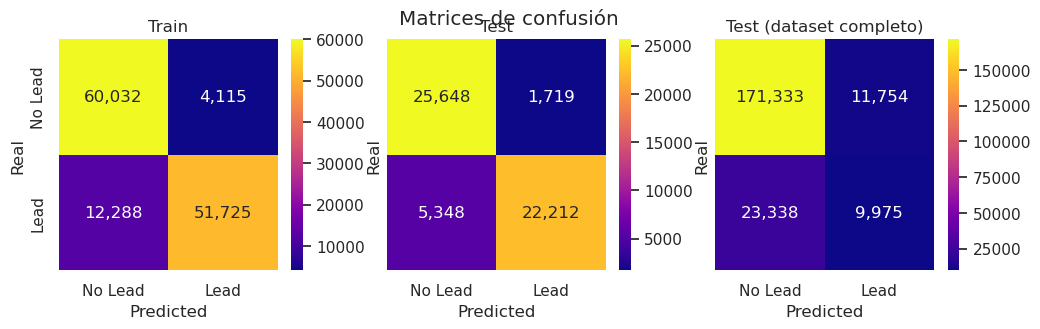

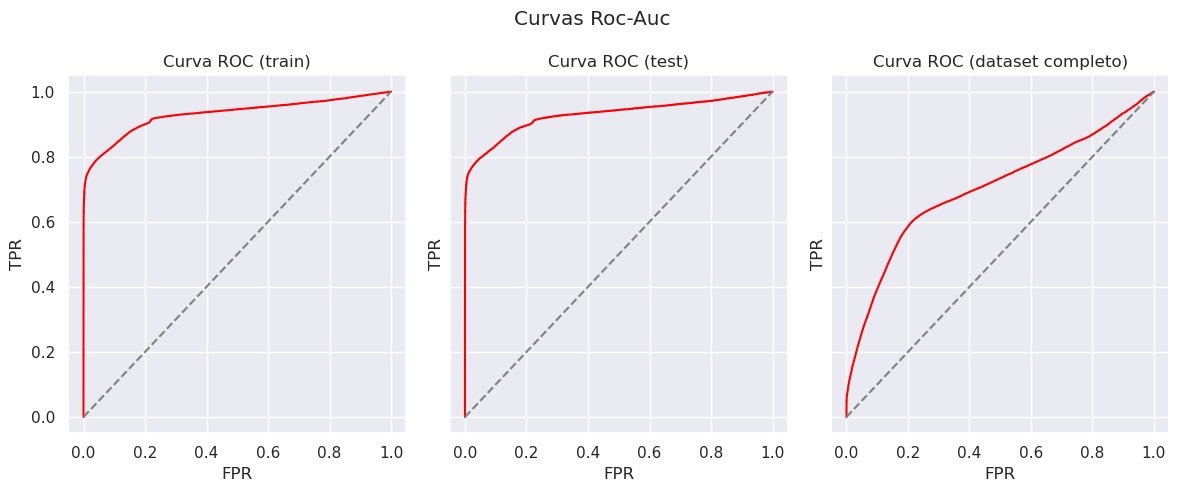

Classifier       Data    Acc  Recall  Precision  \
0  <class 'sklearn.svm._classes.SVC'>      Train  0.872   0.808      0.926   
1  <class 'sklearn.svm._classes.SVC'>       Test  0.871   0.806      0.928   
2  <class 'sklearn.svm._classes.SVC'>  Test Full  0.838   0.299      0.459   

      F1   Roc-Auc  
0  0.863  0.930244  
1  0.863  0.928609  
2  0.362  0.702023

In [54]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_train)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print("Fracción de datos utlizados para set inicial de entrenamiento:", DATA_FRACTION*100,'%')
print()
print('Datos usados para entrenamiento (originales, subsampled, oversampled):',DATA_TO_USE)
print('X_train: {:,d}, X_test: {:,d}, y_train: {:,d}, y_test: {:,d}'.format(X_train.shape[0],X_test.shape[0],y_train.shape[0],y_test.shape[0]))
print()
print('Tiempo para fit operations:',round((duration)/60,2),'minutos')
print()
print("Componentes principales utlizados",maxPC,f'({capturedVarThreshold*100}% de la varianza)')
print()
print("Mejor accuracy gridSearch:", round(best_accuracy,4))
print()
print("Hiperparámetros del mejor modelo de gridsearch:")
print(best_parameters)
print()
print('Pasos del pipeline:')
for s in [str(step) for step in pipe.steps]: print('\t',s)
print()

# creamos un figura con tres subplots (train, test, test original)
target_labels = ['No Lead','Lead']
fig, axes = plt.subplots(1, 3, figsize=(12, 3),sharey=True)


figR, axesR = plt.subplots(1, 3, figsize=(12, 5),sharey=True)


# train
y_pred = best_model.predict(X_train)
y_pred_proba = best_model.predict_proba(X_train)[:, 1]
pmScoreTrain=round(best_model.score(X_train,y_train),3)
pmAccuracyTrain=round(accuracy_score(y_train,y_pred),3)
pmRecallTrain=round(recall_score(y_train,y_pred),3)
pmPrecisionTrain=round(precision_score(y_train,y_pred),3)
pmF1Train=round(f1_score(y_train,y_pred),3)
pmRocAucTrain = roc_auc_score(y_train, y_pred_proba)

cm = confusion_matrix(y_train,y_pred)
ax=axes[0]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Train')

ax=axesR[0]
fpr, tpr, thresholds = roc_curve(y_train, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (train)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")

    
    
    
    
    
# test
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
pmScoreTest=round(best_model.score(X_test,y_test),3)
pmAccuracyTest=round(accuracy_score(y_test,y_pred),3)
pmRecallTest=round(recall_score(y_test,y_pred),3)
pmPrecisionTest=round(precision_score(y_test,y_pred),3)
pmF1Test=round(f1_score(y_test,y_pred),3)
pmRocAucTest = roc_auc_score(y_test, y_pred_proba)

cm = confusion_matrix(y_test,y_pred)
ax=axes[1]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test')

ax=axesR[1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (test)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")









# test con los datos de prueba originales:
#y_pred = best_model.predict(X_test_original)
y_pred = best_model.predict(X_full)
y_pred_proba = best_model.predict_proba(X_full)[:, 1]
#pmScoreTestOrig=round(best_model.score(X_test_original,y_pred),3)
pmScoreTestOrig=round(best_model.score(X_full,y_full),3)
#pmAccuracyTestOrig=round(accuracy_score(y_test_original,y_pred),3)
pmAccuracyTestOrig=round(accuracy_score(y_full,y_pred),3)
#pmRecallTestOrig=round(recall_score(y_test_original,y_pred),3)
pmRecallTestOrig=round(recall_score(y_full,y_pred),3)
#pmPrecisionTestOrig=round(precision_score(y_test_original,y_pred),3)
pmPrecisionTestOrig=round(precision_score(y_full,y_pred),3)
#pmF1TestOrig=round(f1_score(y_test_original, y_pred),3)
pmF1TestOrig=round(f1_score(y_full, y_pred),3)
pmRocAucTestOrig = roc_auc_score(y_full, y_pred_proba)

#cm = confusion_matrix(y_test_original,y_pred)
cm = confusion_matrix(y_full,y_pred)
ax=axes[2]
sns.heatmap(cm,cmap='plasma',annot=True, fmt='g',xticklabels=target_labels,yticklabels=target_labels,ax=ax)
ax.set(xlabel='Predicted',ylabel='Real')
for t in ax.texts: t.set_text('{:,d}'.format(int(float(t.get_text()))))
ax.set_title('Test (dataset completo)')

ax=axesR[2]
fpr, tpr, thresholds = roc_curve(y_full, y_pred_proba)
#plt.figure()
ax.set_title("Curva ROC (dataset completo)") 
ax.plot(fpr,tpr,color='red')
ax.plot([0,1],[0,1],linestyle='--',color='gray')
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")







fig.suptitle('Matrices de confusión')
figR.suptitle('Curvas Roc-Auc')
plt.tight_layout()
plt.show()












classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Train',
                                                                  pmAccuracyTrain, pmRecallTrain, pmPrecisionTrain, pmF1Train,pmRocAucTrain
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test',
                                                                  pmAccuracyTest, pmRecallTest, pmPrecisionTest, pmF1Test,pmRocAucTest
                                                                  ] 

classifiersPerformances.loc[len(classifiersPerformances.index)] = [type(pipe['classifier']),'Test Full',
                                                                  pmAccuracyTestOrig, pmRecallTestOrig, pmPrecisionTestOrig, pmF1TestOrig,pmRocAucTestOrig
                                                                  ] 

display(classifiersPerformances)

if type(classifier) == type(RandomForestClassifier(n_jobs=-1)):
    if SCALER:
        X_train_scaled = scaler.fit_transform(X_train)
        X_train = X_train_scaled
        
    if DIMRED:
        pca = PCA(n_components=maxPC)
        X_train_red = pca.fit_transform(X_train)
        X_train = X_train_red
    
    feature_cols = pd.DataFrame(X_train_red).columns.to_list()
    classifier.fit(X_train,y_train)
    
    importances = pd.DataFrame({'feature':feature_cols,'importancia':np.round(classifier.feature_importances_,3)})
    importances.sort_values(by='importancia',ascending=False,inplace=True)
    importances.set_index('feature')
    print(importances)



### Clustering con DBSCAN

In [69]:
modelo = DBSCAN(eps=500, min_samples=300)
yhat = modelo.fit_predict(X)
clusters = [j for j in np.unique(yhat) if j!=-1]
print(clusters)

[]


Clientes que no fueron agregados a un cluster: 0 / 183087


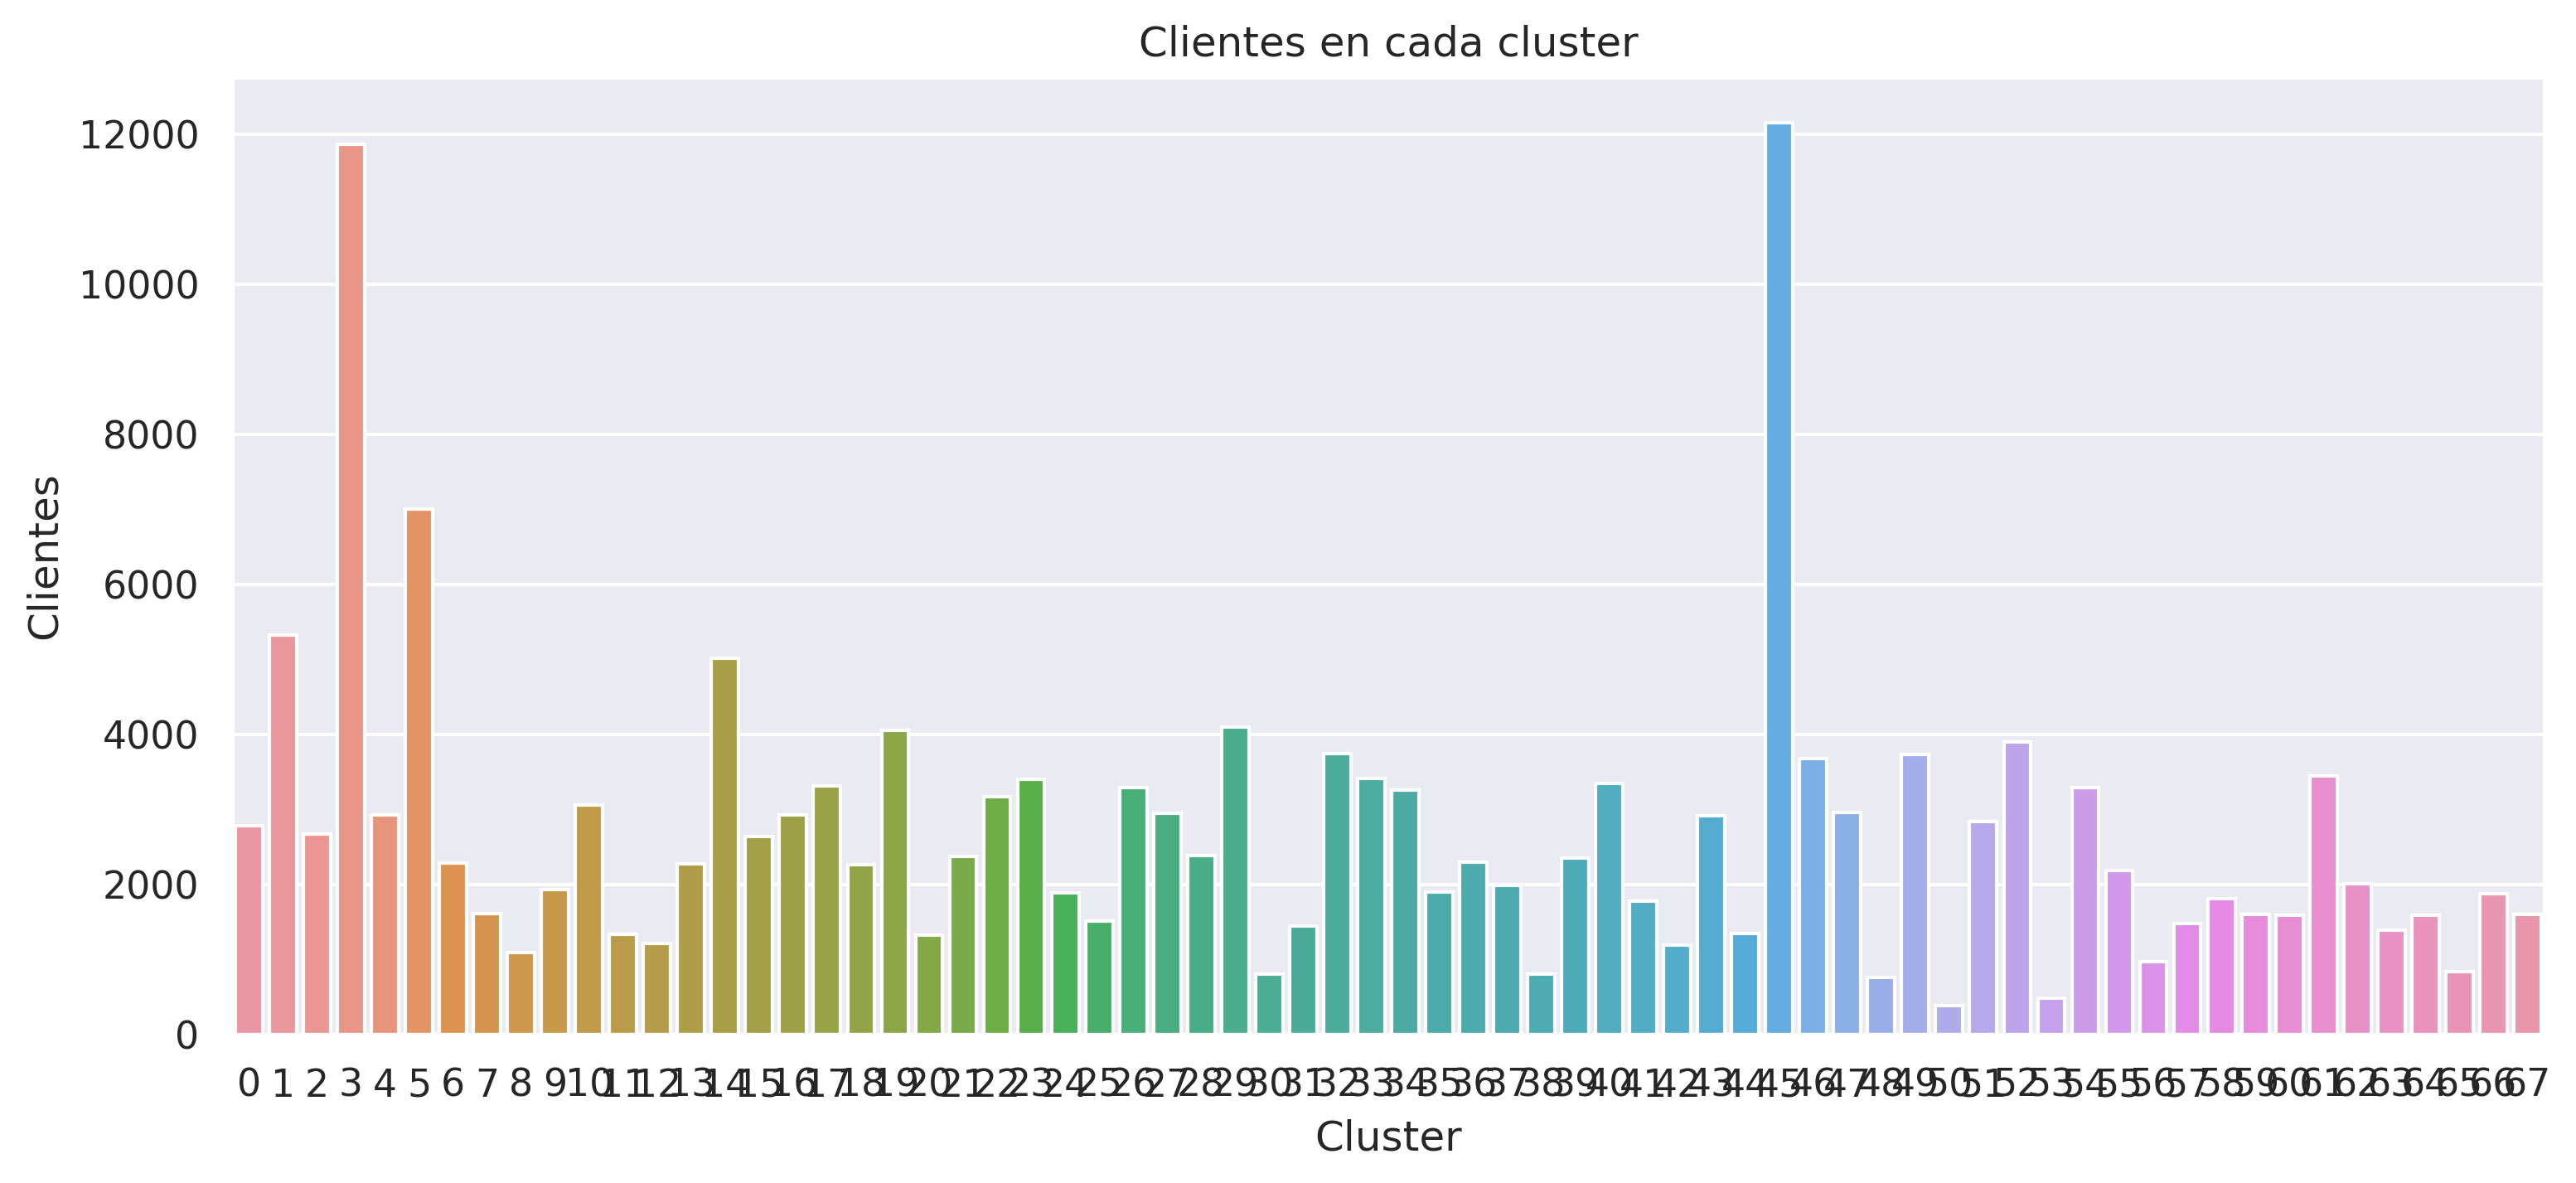

El total de clientes en clusters es de: 183087
Estadísticas descriptivas del cluster 0:


Age      Vintage  Avg_Account_Balance  Gender_Male  \
count  2778.000000  2778.000000         2.778000e+03  2778.000000   
mean     49.984161    61.751620         1.213487e+06     0.834773   
std      10.541980    26.576397         8.689246e+05     0.371452   
min      25.000000     7.000000         1.570090e+05     0.000000   
25%      43.000000    38.000000         6.568120e+05     1.000000   
50%      49.000000    65.000000         1.004268e+06     1.000000   
75%      57.000000    85.000000         1.466025e+06     1.000000   
max      83.000000   126.000000         8.764249e+06     1.000000   

       Occupation_Entrepreneur  Occupation_Other  Occupation_Salaried  \
count                   2778.0            2778.0          2778.000000   
mean                       0.0               0.0             0.077394   
std                        0.0               0.0             0.267263   
min                        0.0               0.0             0.000000   
25%                        0.0               0.0             0.000000   
50%                        0.0               0.0             0.000000   
75%                        0.0               0.0             0.000000   
max                        0.0               0.0             1.000000   

       Occupation_Self_Employed  Is_Active_Yes  Credit_Product_Yes  ...  \
count                    2778.0    2778.000000         2778.000000  ...   
mean                        0.0       0.694744            0.077394  ...   
std                         0.0       0.460599            0.267263  ...   
min                         0.0       0.000000            0.000000  ...   
25%                         0.0       0.000000            0.000000  ...   
50%                         0.0       1.000000            0.000000  ...   
75%                         0.0       1.000000            0.000000  ...   
max                         0.0       1.000000            1.000000  ...   

       Region_Code_RG277  Region_Code_RG278  Region_Code_RG279  \
count        2778.000000             2778.0             2778.0   
mean            0.007559                0.0                0.0   
std             0.086631                0.0                0.0   
min             0.000000                0.0                0.0   
25%             0.000000                0.0                0.0   
50%             0.000000                0.0                0.0   
75%             0.000000                0.0                0.0   
max             1.000000                0.0                0.0   

       Region_Code_RG280  Region_Code_RG281  Region_Code_RG282  \
count        2778.000000        2778.000000        2778.000000   
mean            0.008639           0.001440           0.002160   
std             0.092562           0.037925           0.046432   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG283  Region_Code_RG284      Is_Lead  Cluster  
count        2778.000000        2778.000000  2778.000000   2778.0  
mean            0.032037           0.019078     0.983801      0.0  
std             0.176131           0.136826     0.126262      0.0  
min             0.000000           0.000000     0.000000      0.0  
25%             0.000000           0.000000     1.000000      0.0  
50%             0.000000           0.000000     1.000000      0.0  
75%             0.000000           0.000000     1.000000      0.0  
max             1.000000           1.000000     1.000000      0.0  

[8 rows x 51 columns]

In [65]:
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(12,5), dpi=300)
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xlabel("Cluster")
plt.ylabel("Clientes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())
print('Estadísticas descriptivas del cluster 0:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==0].describe())



**Observaciones:**

Los clientes dentro de cada cluster deben tener características similares. Revisando las desviaciones estándar de cada feature podemos hacernos cierta idea de las features que comparten:

#### Desviación estándar de cada feature de los datos del un par de clusters:

In [57]:
clusterNumber = 5
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                       0.000000
Region_Code_RG253             0.000000
Region_Code_RG262             0.000000
Region_Code_RG271             0.054393
Region_Code_RG250             0.054393
Region_Code_RG274             0.054393
Region_Code_RG276             0.054393
Region_Code_RG255             0.054393
Region_Code_RG265             0.054393
Occupation_Entrepreneur       0.054393
Region_Code_RG278             0.076809
Region_Code_RG281             0.093931
Region_Code_RG275             0.093931
Region_Code_RG258             0.093931
Region_Code_RG266             0.093931
Region_Code_RG272             0.108300
Region_Code_RG263             0.108300
Region_Code_RG267             0.108300
Region_Code_RG256             0.108300
Region_Code_RG260             0.108300
Region_Code_RG259             0.120902
Region_Code_RG279             0.132243
Region_Code_RG284             0.142623
Region_Code_RG264             0.152240
Region_Code_RG252             0.152240
Channel_Code_X4          

In [58]:
clusterNumber = 9
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                        0.000000
Region_Code_RG253              0.000000
Region_Code_RG276              0.041345
Region_Code_RG265              0.058420
Region_Code_RG275              0.058420
Region_Code_RG271              0.058420
Region_Code_RG274              0.058420
Region_Code_RG255              0.071489
Occupation_Entrepreneur        0.082477
Region_Code_RG278              0.082477
Region_Code_RG258              0.108825
Region_Code_RG279              0.108825
Region_Code_RG266              0.108825
Region_Code_RG267              0.108825
Region_Code_RG273              0.116238
Region_Code_RG264              0.116238
Channel_Code_X4                0.116238
Region_Code_RG250              0.116238
Region_Code_RG262              0.123182
Region_Code_RG272              0.123182
Region_Code_RG281              0.129733
Region_Code_RG254              0.129733
Region_Code_RG260              0.129733
Region_Code_RG269              0.129733
Region_Code_RG282              0.135946


### Clustering con Jerárquico usando PCA

In [59]:
# TODO: remove these X and y assigns (already in appropiate cell):
#X = X_oversampled
#y = y_oversampled

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
X_red = pca.fit_transform(X_scaled)

explained_variance_ratios = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratios)
for i in range(2):
    print(f"Varianza explicada para el componente {i+1}: {explained_variance_ratios[i]}")
print(f"Varianza acumulada para {2} componentes: {cumulative_variance[2-1]}")

modelo = AgglomerativeClustering(distance_threshold=5.0,
                                 n_clusters=None,
                                 compute_full_tree=True)

#modelo = DBSCAN(eps=5000, min_samples=50) # no logré un clustering con DBSCAN sobre este dataset

yhat = modelo.fit_predict(X_red)
clusters = [j for j in np.unique(yhat) if j!=-1]
print("Clusters:")
print(clusters)


Varianza explicada para el componente 1: 0.19093928398233875
Varianza explicada para el componente 2: 0.10867621772398454
Varianza acumulada para 2 componentes: 0.2996155017063233
Clusters:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67]


Clientes que no fueron agregados a un cluster: 0 / 183087


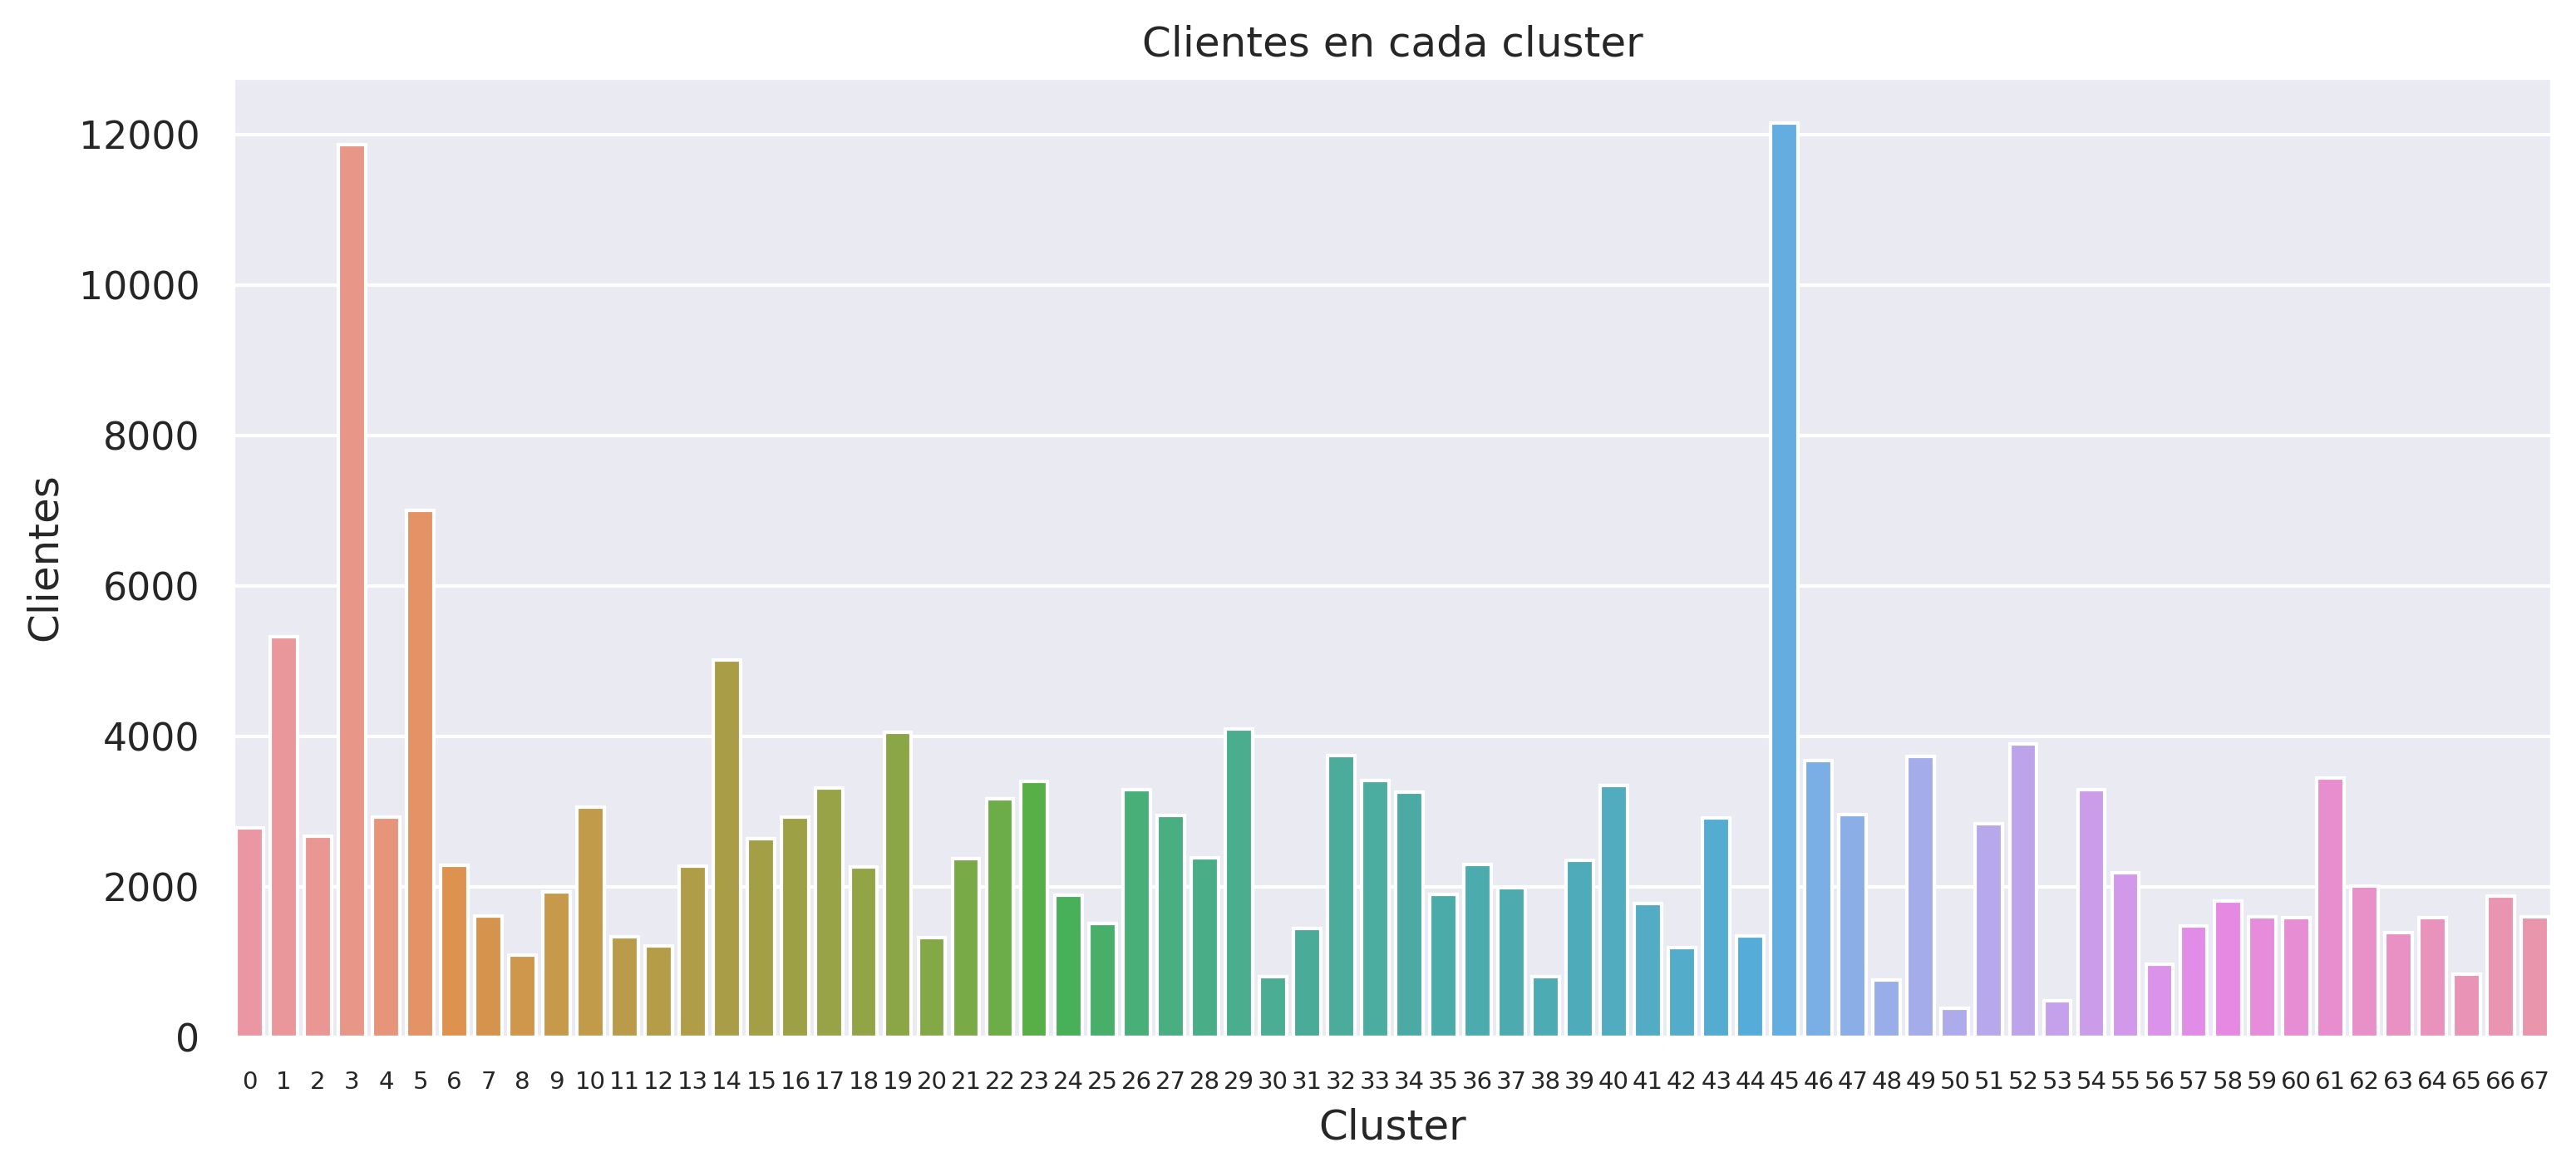

El total de clientes en clusters es de: 183087
Estadísticas descriptivas del cluster 6:


Age      Vintage  Avg_Account_Balance  Gender_Male  \
count  2282.000000  2282.000000         2.282000e+03  2282.000000   
mean     55.865907    55.340053         1.289368e+06     0.464067   
std      13.234024    27.747358         9.741413e+05     0.498816   
min      25.000000     7.000000         1.460130e+05     0.000000   
25%      46.000000    31.000000         7.090025e+05     0.000000   
50%      55.000000    55.000000         1.052268e+06     0.000000   
75%      66.000000    79.000000         1.546452e+06     1.000000   
max      85.000000   127.000000         8.786057e+06     1.000000   

       Occupation_Entrepreneur  Occupation_Other  Occupation_Salaried  \
count              2282.000000       2282.000000               2282.0   
mean                  0.028484          0.763365                  0.0   
std                   0.166387          0.425109                  0.0   
min                   0.000000          0.000000                  0.0   
25%                   0.000000          1.000000                  0.0   
50%                   0.000000          1.000000                  0.0   
75%                   0.000000          1.000000                  0.0   
max                   1.000000          1.000000                  0.0   

       Occupation_Self_Employed  Is_Active_Yes  Credit_Product_Yes  ...  \
count                    2282.0    2282.000000              2282.0  ...   
mean                        0.0       0.115688                 1.0  ...   
std                         0.0       0.319921                 0.0  ...   
min                         0.0       0.000000                 1.0  ...   
25%                         0.0       0.000000                 1.0  ...   
50%                         0.0       0.000000                 1.0  ...   
75%                         0.0       0.000000                 1.0  ...   
max                         0.0       1.000000                 1.0  ...   

       Region_Code_RG277  Region_Code_RG278  Region_Code_RG279  \
count        2282.000000        2282.000000        2282.000000   
mean            0.017967           0.004382           0.012270   
std             0.132859           0.066067           0.110112   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG280  Region_Code_RG281  Region_Code_RG282  \
count        2282.000000        2282.000000        2282.000000   
mean            0.024102           0.007011           0.006573   
std             0.153398           0.083458           0.080826   
min             0.000000           0.000000           0.000000   
25%             0.000000           0.000000           0.000000   
50%             0.000000           0.000000           0.000000   
75%             0.000000           0.000000           0.000000   
max             1.000000           1.000000           1.000000   

       Region_Code_RG283  Region_Code_RG284      Is_Lead  Cluster  
count        2282.000000        2282.000000  2282.000000   2282.0  
mean            0.085013           0.051271     0.683173      6.0  
std             0.278962           0.220598     0.465341      0.0  
min             0.000000           0.000000     0.000000      6.0  
25%             0.000000           0.000000     0.000000      6.0  
50%             0.000000           0.000000     1.000000      6.0  
75%             0.000000           0.000000     1.000000      6.0  
max             1.000000           1.000000     1.000000      6.0  

[8 rows x 51 columns]

In [64]:
XWithYAndCluster = pd.concat((X.reset_index(drop=True),y.reset_index(drop=True),pd.DataFrame(yhat,columns=['Cluster'])), axis=1)

print("Clientes que no fueron agregados a un cluster:",XWithYAndCluster[XWithYAndCluster.Cluster==-1].shape[0],'/',XWithYAndCluster.shape[0])

clientesEnClustersTotales=0
clientesEnClusters=[]
for cluster in clusters:
    clientesEnClusters.append( XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0] )
    clientesEnClustersTotales += XWithYAndCluster[XWithYAndCluster.Cluster==cluster].shape[0]

plt.figure(figsize=(12,5),dpi=300)
sns.barplot(x=np.arange(len(clientesEnClusters)), y=clientesEnClusters)
plt.xticks(fontsize=7)
plt.xlabel("Cluster")
plt.ylabel("Clientes")
plt.title("Clientes en cada cluster")
plt.show()

print('El total de clientes en clusters es de:',clientesEnClustersTotales)
#display(XWithYAndCluster.head())
print('Estadísticas descriptivas del cluster 6:')
display(XWithYAndCluster[XWithYAndCluster.Cluster==6].describe())


#### Desviación estándar de cada feature de un cluster:

In [61]:
clusterNumber = 7
stds=XWithYAndCluster[(XWithYAndCluster.Cluster==clusterNumber)]
stds.describe().loc['std'].sort_values()

Cluster                          0.000000
Occupation_Entrepreneur          0.000000
Occupation_Self_Employed         0.000000
Region_Code_RG256                0.000000
Region_Code_RG271                0.000000
Region_Code_RG278                0.024930
Region_Code_RG266                0.024930
Region_Code_RG276                0.024930
Region_Code_RG262                0.024930
Region_Code_RG253                0.024930
Region_Code_RG265                0.043153
Region_Code_RG259                0.043153
Region_Code_RG267                0.049813
Region_Code_RG252                0.049813
Region_Code_RG255                0.049813
Channel_Code_X2                  0.049813
Region_Code_RG250                0.049813
Region_Code_RG258                0.055676
Region_Code_RG260                0.055676
Region_Code_RG274                0.060971
Region_Code_RG263                0.065835
Region_Code_RG279                0.065835
Region_Code_RG282                0.065835
Region_Code_RG273                0

**Observaciones:**

Podríamos encontrar qué cluster se basa más en cierta feature, Vintage, por ejemplo si comparamos la desviación estándar de cada cluster y encontramos cuál cluster tiene menos.

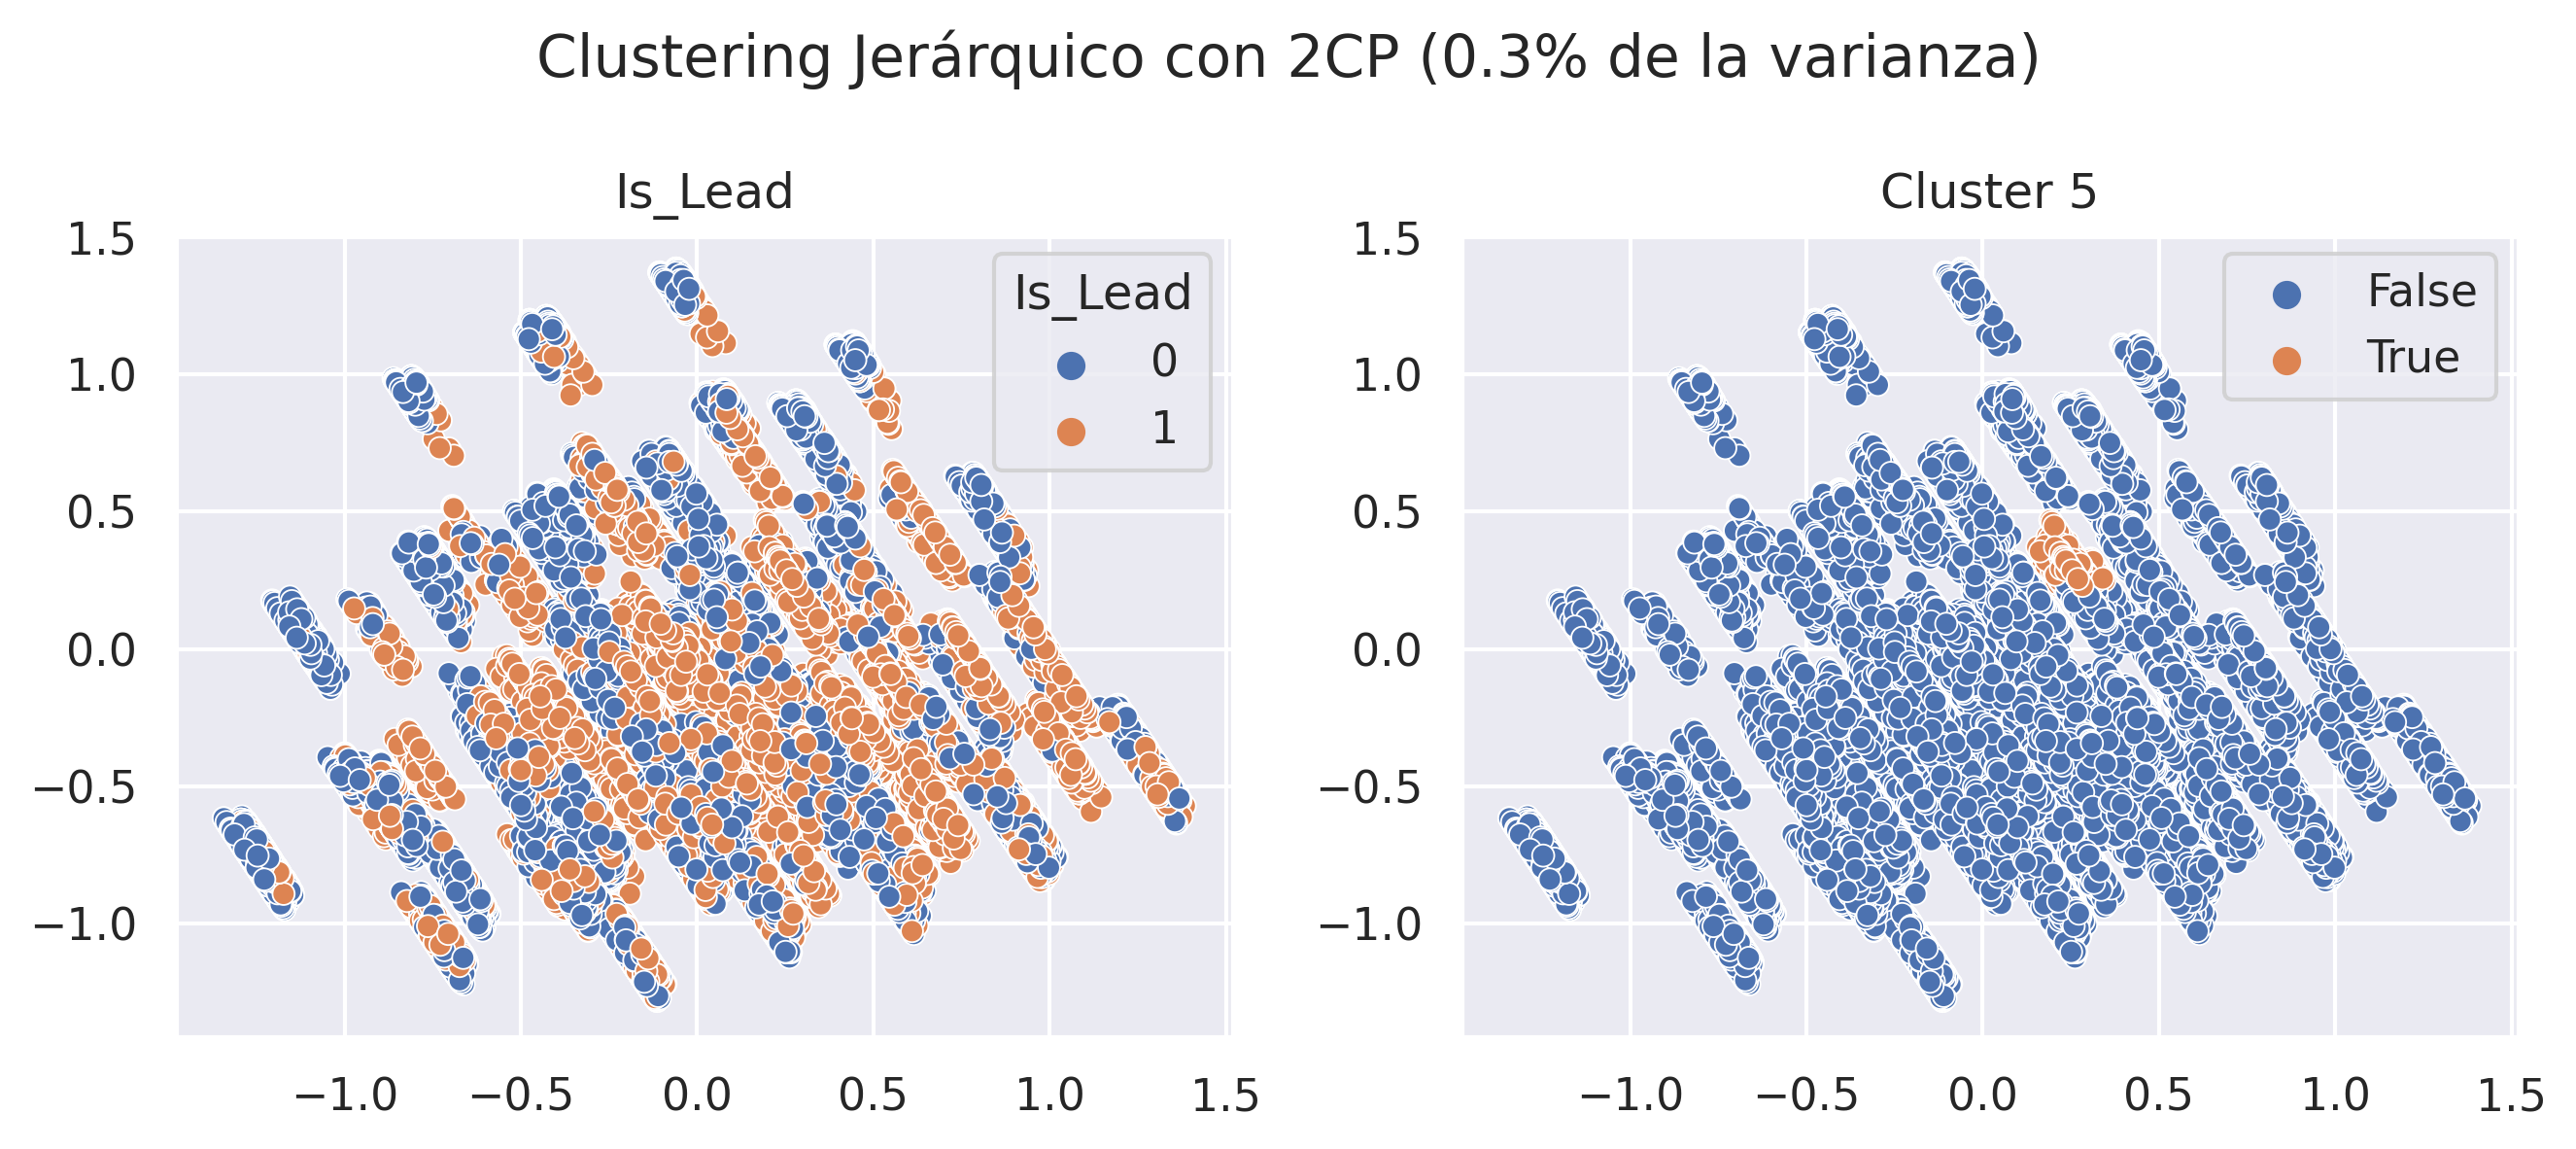

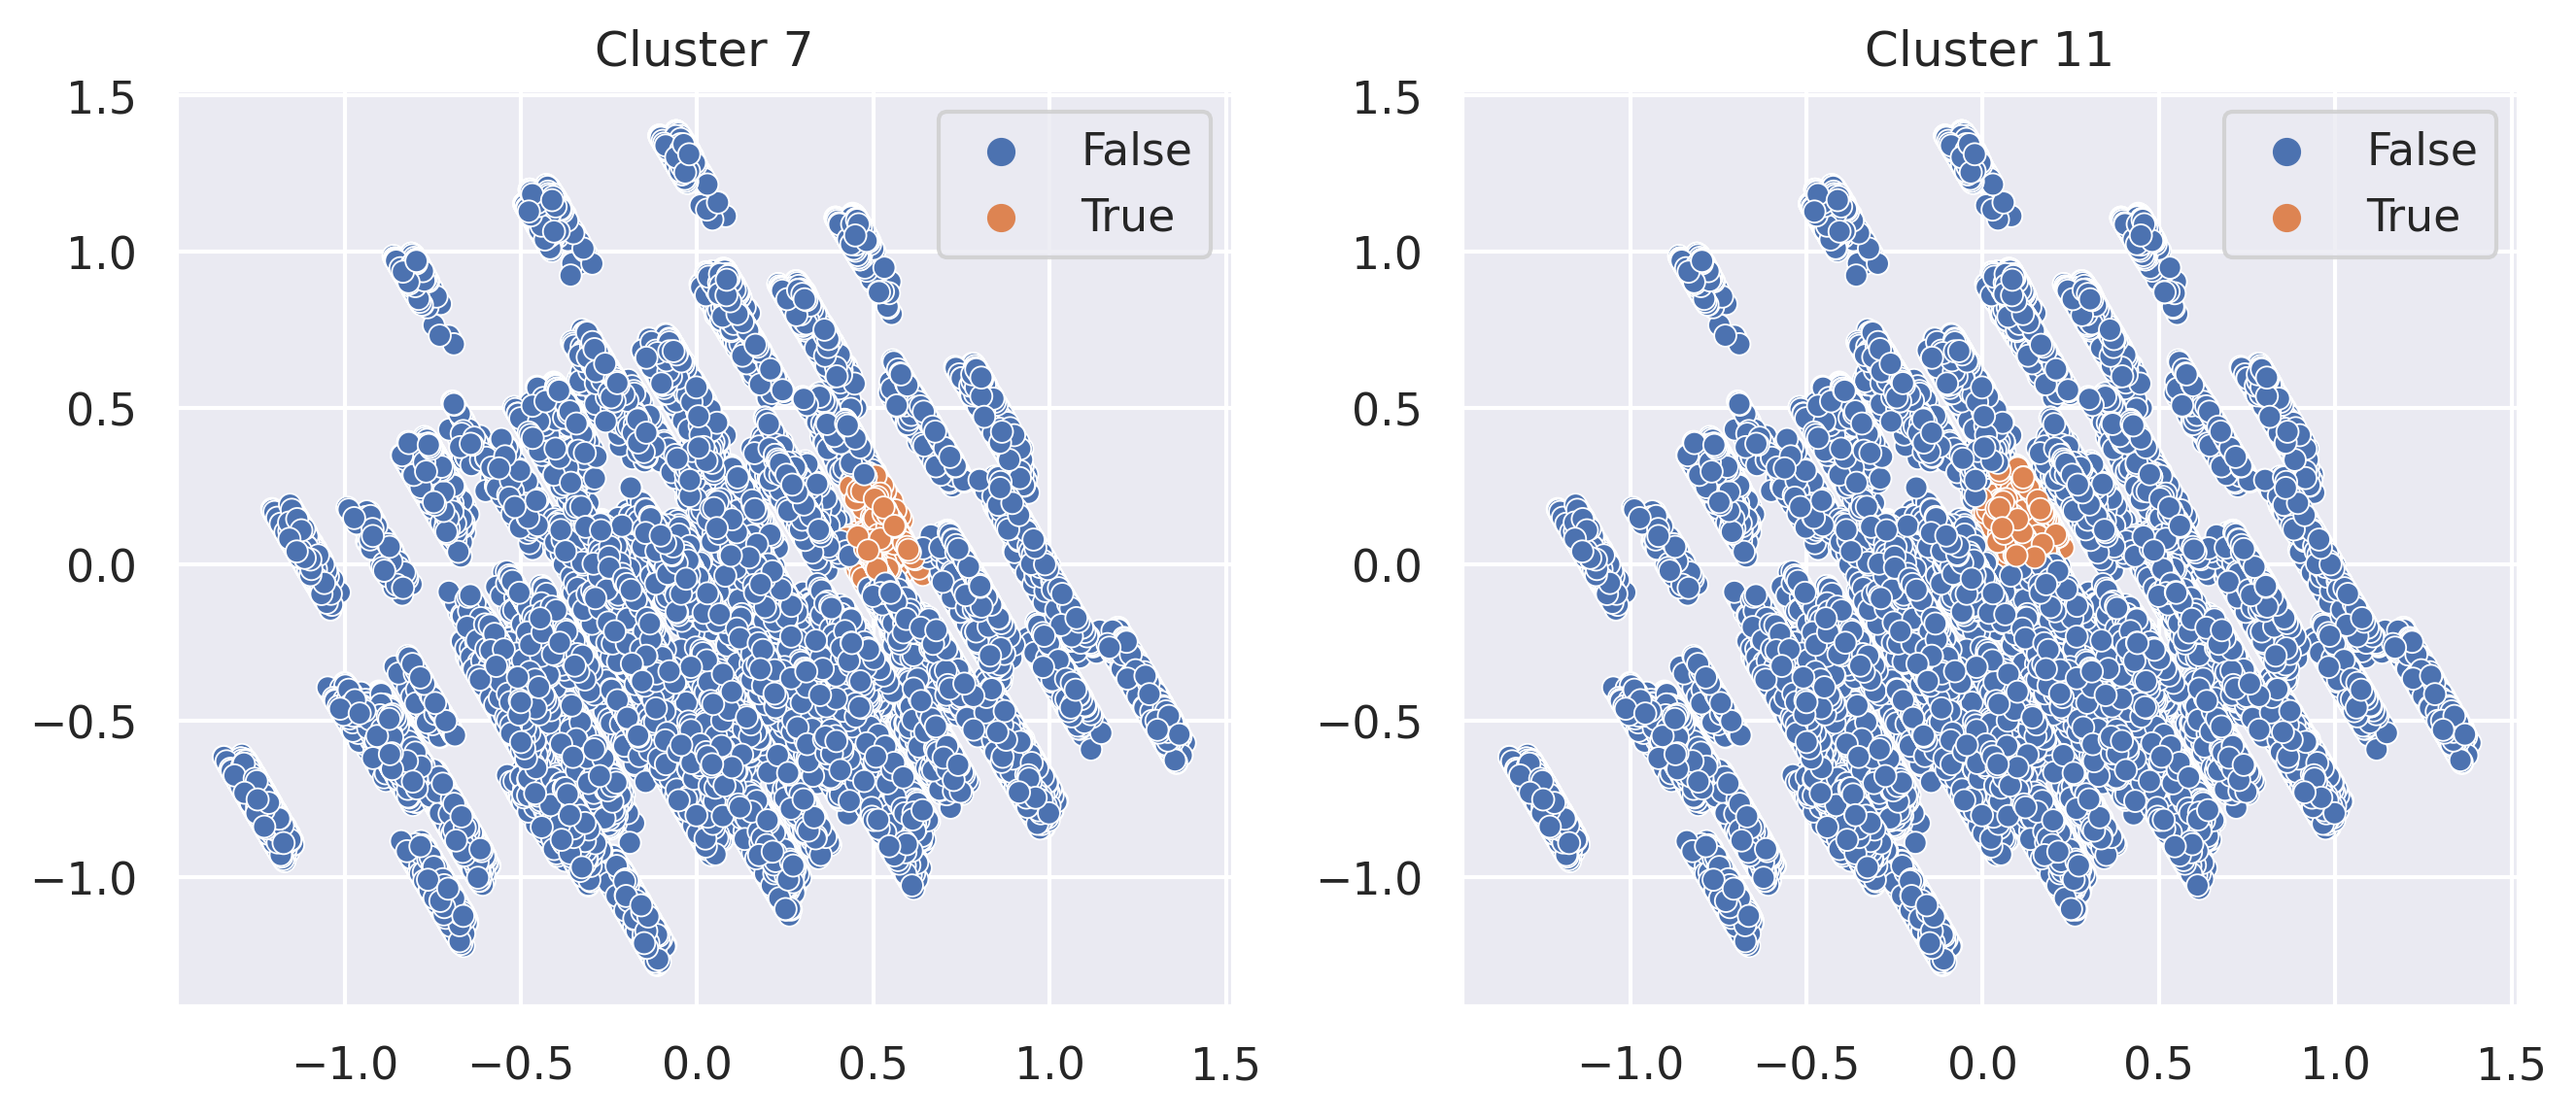

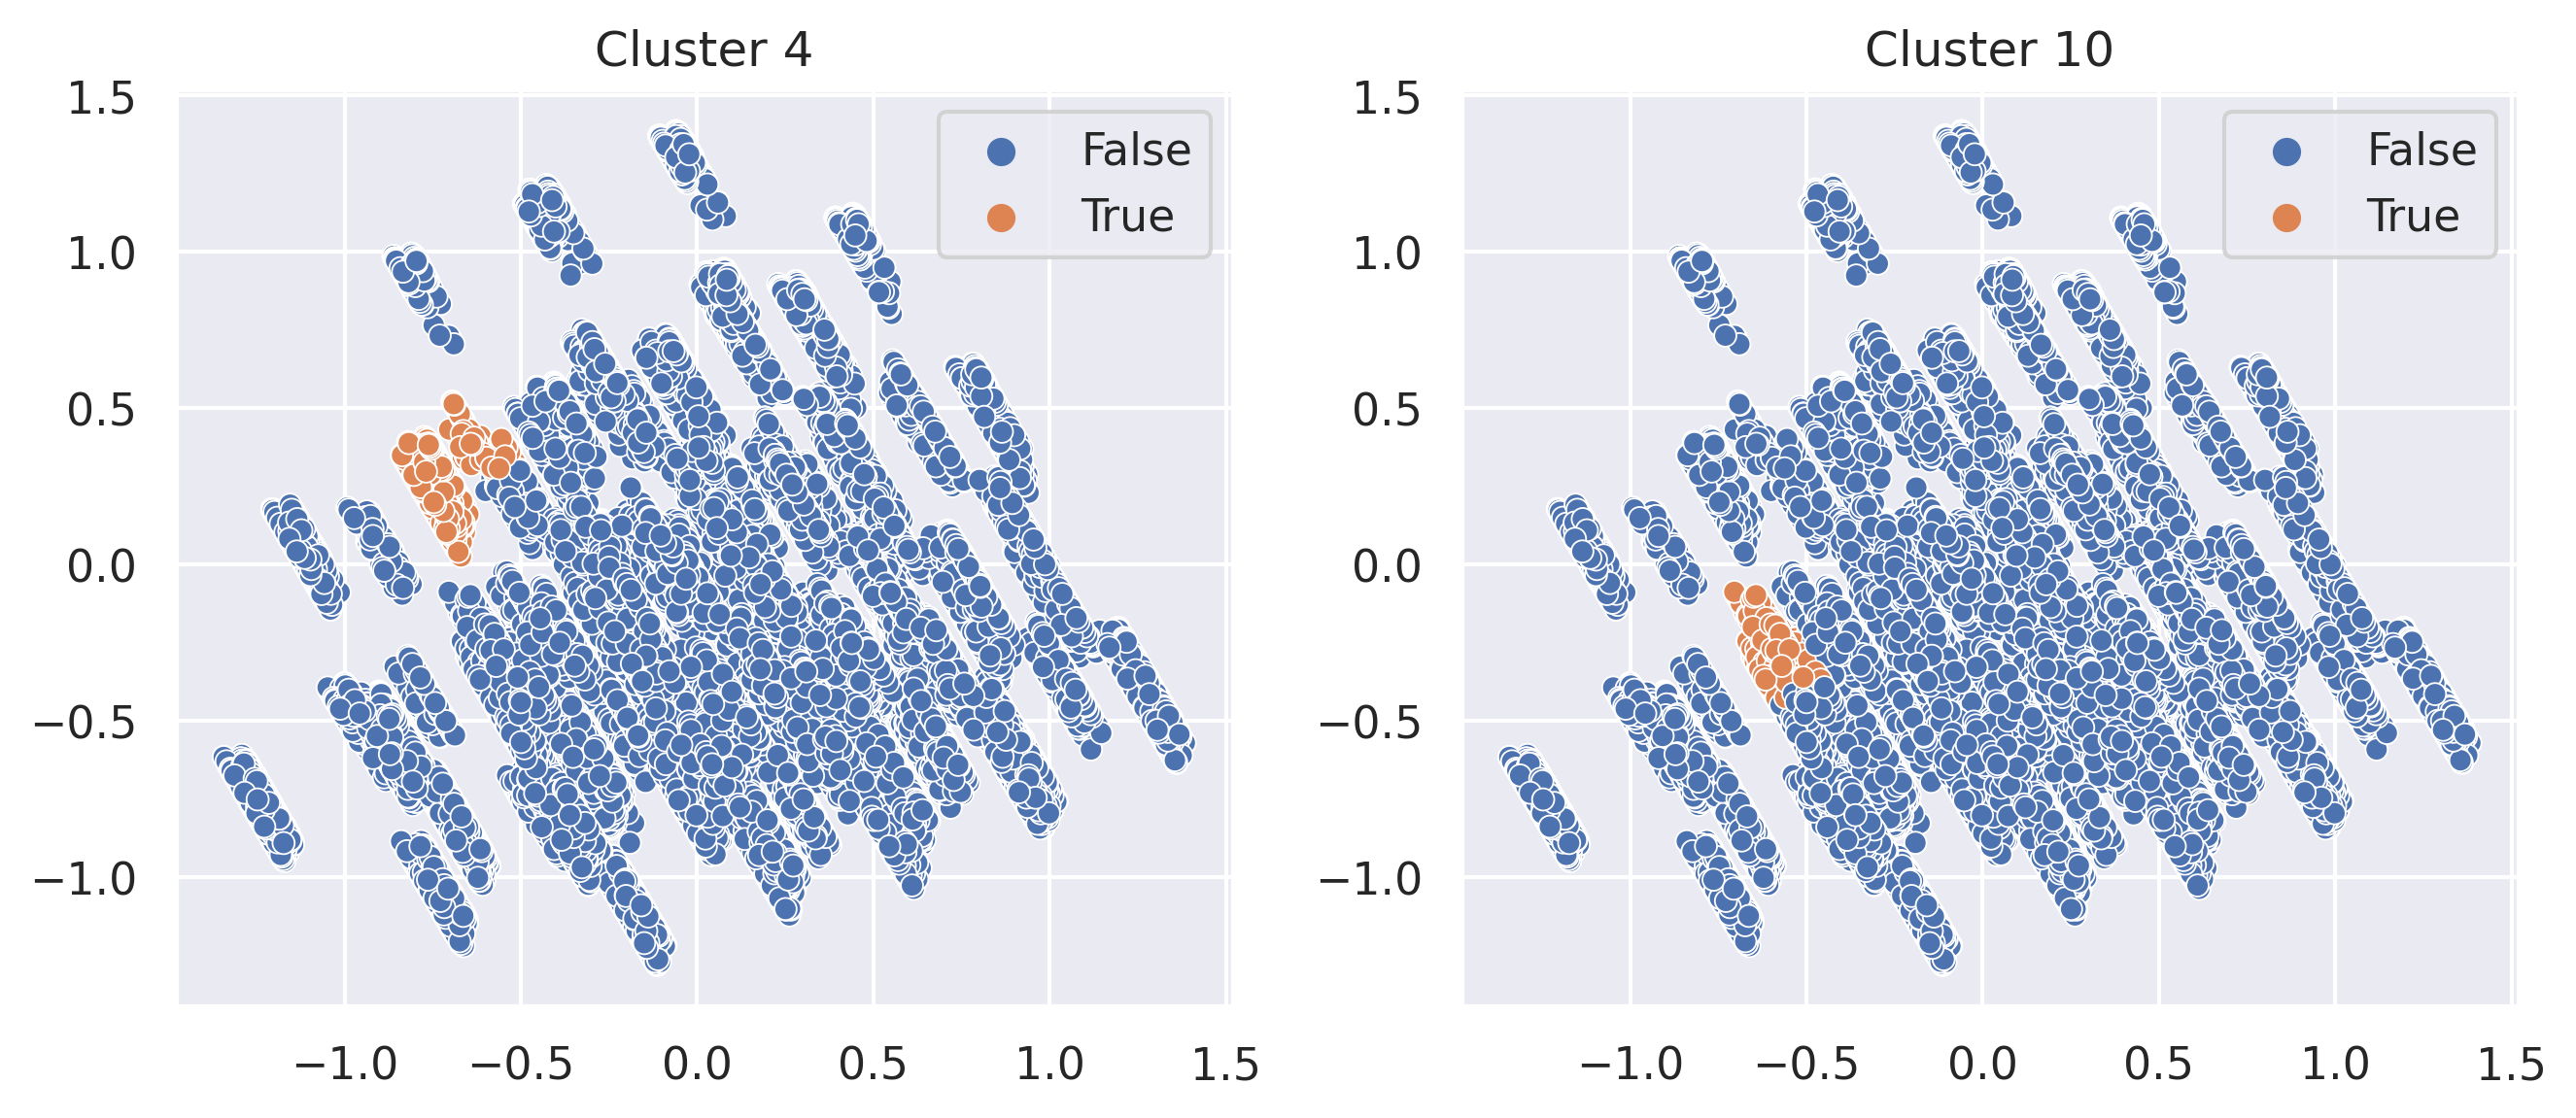

In [62]:
# plotting de clusters
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = y, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Is_Lead')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==5, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 5')
plt.suptitle(f'Clustering Jerárquico con 2CP ({round(cumulative_variance[-1],3)}% de la varianza)')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==7, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 7')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==11, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 11')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 4),dpi=300)
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==4, palette='deep', ax=axes[0], s=30)
axes[0].set_title('Cluster 4')
sns.scatterplot(x = X_red[:,1], y = X_red[:,0], hue = yhat==10, palette='deep', ax=axes[1], s=30)
axes[1].set_title('Cluster 10')
plt.tight_layout()
plt.show()

## Conclusiones

El trabajo realizado fue de inmensa utilidad para comprender más la implementación de muchos modelos y técnicas vistas en el módulo dos del diplomado.

El análisis de cluster puede revelar conocimientos de los datos que en primera instancia están muy ocultos.

El tamaño del dataset es un factor principal a tomar en cuenta al acercarse a un problema donde pueda aplicarse ML y en el caso del trabajo aquí presentado fue una de las carácteríticas más dificil de tratar para llegar a buenos modelos de clasificación.

Es necesario consultar continuamente la documentación de las implementaciones en Python así como la teoría detrás de cada modelo y algoritmos para familiarizarse plenamente con la materia.

El dataset y planteamiento del problema fue parte de un job-a-ton. La tabla de ranking de soluciones de varias pesonas se encuentra en https://datahack.analyticsvidhya.com/contest/job-a-thon-2/#LeaderBoard 

El máximo score alcanzado hasta ahora por la comunidad es de 0.8735155589